# Purpose
The purpose of this notebook is to collect the raw data and perform analyses required to generate Figure 3.

# Preliminaries

## load packages

In [5]:
%matplotlib inline
%autosave 60
%load_ext autoreload
%autoreload 2

#filesystem
import re
import os
import glob
from pathlib import Path
from tqdm import tqdm

#plotting
import seaborn as sns
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as patches
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from PIL import Image
from dateutil import rrule
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap, Normalize

#data
import numpy as np
import pandas as pd
import random
import ast
import pickle
import networkx as nx
import community
from datetime import datetime, timedelta, time
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.ndimage import gaussian_filter
from scipy.io import wavfile

# custom modules
from src import parameters,rfid, plot
from src import timestamps
from src import preprocess

Autosaving every 60 seconds
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## set paths

In [6]:
# project root - to reproduce, change root to the full path to mouse_barn_audiomoth on your computer
#root = 'path/to/proc_B_data_submission/'
root = '/Users/jourjine/Desktop/lindholm/barn_manuscript_final/public_repositories/wild-mus-vocal-ecology'

# paths to rfid reading directories (each contains a directory for meets, stays, and box events)
all_rfid = os.path.join(root, 'data', 'rfid') # path to rfid data from 2013-2023 ("all")

# path to adult phenotypes (sex)
sexes_path = os.path.join(root, 'data', 'phenotypes', 'sexes.csv')
demography_metadata_path = os.path.join(root, 'data', 'phenotypes', 'All_popul_checks_update2023_transponder-and-popchecks.csv')

# path to data on litters born
pups_metadata_path = os.path.join(root, 'data', 'phenotypes', 'pups.csv')

## get sex and transponder ID data

In [7]:
# make a dictionary mapping transponder ID to sex
sexes = pd.read_csv(sexes_path, low_memory=False)
sex_dict = sexes.set_index('transponder_ID')['Sex'].to_dict()

# color them
sex_colors = {}
sex_colors['M'] = 'tomato'
sex_colors['F'] = 'skyblue'
sex_colors[float('NaN')] = 'grey'

# Get the raw data

In [8]:
# meets 2022-2023 - only need this range
print('getting meets 2022-2023...')
start = 20220601 # date to start aggregating in yyymmdd format (you will probably crash the kernel if you try to read all the meet data)
meets = pd.concat([pd.read_feather(i) for i in glob.glob(os.path.join(all_rfid, 'mouse_meets', '*.feather')) if int(os.path.basename(i)[:8]) >= start])
meets = preprocess.raw_data_from_cloud_of_mice(meets, df_type='meets')

# stays by individual
stays = pd.concat([pd.read_feather(i) for i in glob.glob(os.path.join(all_rfid,  'mouse_stays', '*.feather'))])
stays = stays.rename(columns={'box_number':'box'})
stays = preprocess.raw_data_from_cloud_of_mice(stays, df_type='stays')
stays['season'] = ['summer' if (i.month in [6,7,8]) else \
                   'autumn' if i.month in [9,10,11] else \
                   'winter' if i.month in [12,1,2] else \
                   'spring' for i in stays['entry_time']]
stays = stays[stays['time_in_secs'] > 0] # drop the 4 stays with negative stay length

# stays by box
box_events = pd.concat([pd.read_feather(i) for i in glob.glob(os.path.join(all_rfid, 'box_events', '*.feather'))])
box_events = preprocess.raw_data_from_cloud_of_mice(box_events, df_type='box_events')
box_events['year'] = box_events['event_time'].dt.year
box_events['month'] = box_events['event_time'].dt.month
box_events['season'] = ['summer' if (i.month in [6,7,8]) else \
                       'autumn' if i.month in [9,10,11] else \
                       'winter' if i.month in [12,1,2] else \
                       'spring' for i in box_events['event_time']]

#pups 2013-2023
pups = pd.read_csv(pups_metadata_path)

getting meets 2022-2023...
Preprocessing a meets table with 23409181 rows...
	...found 5499 duplicates
		...dropped them.
	...found 2419749 0s long meets
		 ...dropped them.
	...dropping closed boxes
		...done.
	...adding season to meets
		...done.
	...adding columns for overlap start and end in UTC
		...done.
	...additing columns for year, month, day, and hour
		...done.


/var/folders/h6/6fyt3jld5pq_w03ql1jw0gnh0000gn/T/ipykernel_7542/2241767887.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  stays = pd.concat([pd.read_feather(i) for i in glob.glob(os.path.join(all_rfid,  'mouse_stays', '*.feather'))])


Preprocessing a stays table with 44185198 rows...
	...found 7102 duplicates
		...dropped them.
	...found 3534433 0s long stays
		...dropped them.
	...adding season to stays
		...done.
	...adding columns for stay start and end in UTC
		...done.
	...adding columns for year, month, day, and hour
		...done.


/var/folders/h6/6fyt3jld5pq_w03ql1jw0gnh0000gn/T/ipykernel_7542/2241767887.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  box_events = pd.concat([pd.read_feather(i) for i in glob.glob(os.path.join(all_rfid, 'box_events', '*.feather'))])


Preprocessing a box_events table with 88326782 rows...
	...naming 'num_partners_after_event' to 'occupancy_after_event'
		...done.
	...adding column for box
		...done.
	...adding column for date
		...done.


In [9]:
# define start and end of data (note that )
dataset_start, dataset_end = pd.to_datetime('2013-01-01 00:00:00'), pd.to_datetime('2024-01-01 00:00:00')

#subset by start and end
stays = stays[(stays['entry_time'] >= dataset_start) & 
              (stays['exit_time'] <= dataset_end)]
box_events = box_events[(box_events['event_time'] >= dataset_start) & 
                        (box_events['event_time'] <= dataset_end)]

# minimum stay to consider for the purpose of this figure 
min_stay = 0.01

# add sex and stay time in minutes for convenience
stays['time_in_secs'] = stays['time_in_secs'].astype(float)
stays['time_in_minutes'] = stays['time_in_secs']/(60)
stays['sex'] = stays['transponder_id'].map(sex_dict)

# drop odd numbered boxes after winter 2020 
# these are readings from RFID readers that are connected to RFID system but no longer attached to boxes
stays = stays[~((stays['box'] % 2 != 0) & (stays['year'] >= 2021))]
box_events = box_events[~((box_events['box'] % 2 != 0) & (box_events['year'] >= 2021))]


# Organize the raw data

## Get mice shared across seasons 2022-2023 (panel A)

/var/folders/h6/6fyt3jld5pq_w03ql1jw0gnh0000gn/T/ipykernel_7542/3202541692.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stays_2022_2023['season'] = stays_2022_2023['entry_time'].apply(lambda x: timestamps.get_season_from_date(x))


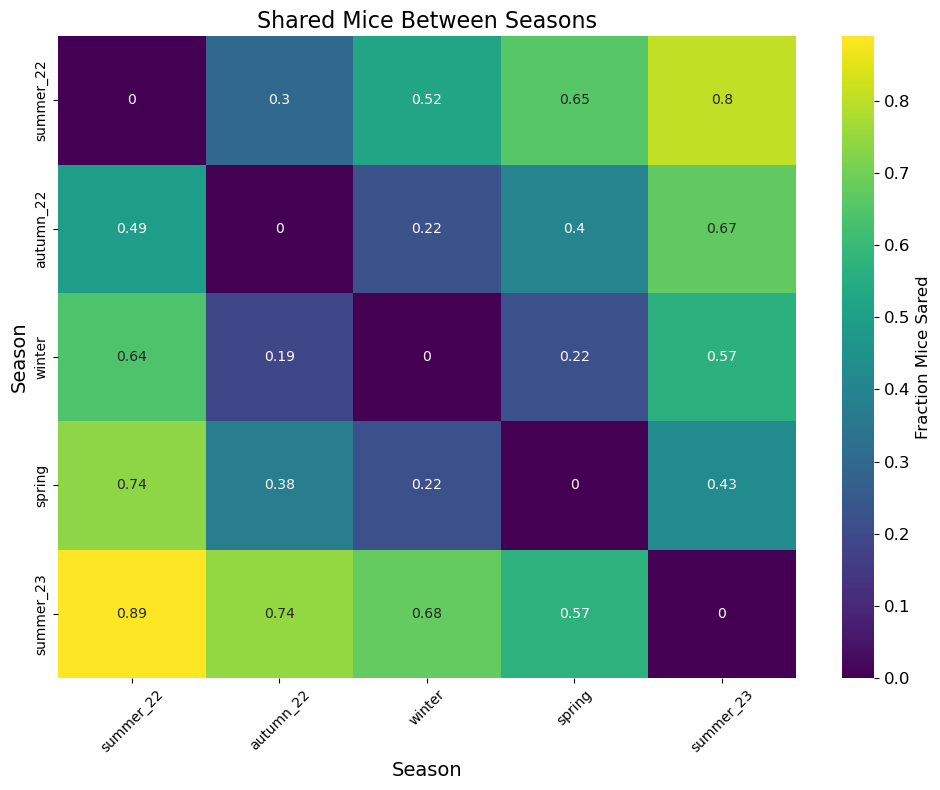

In [10]:
# sub-set to the appropriate months/years
stays_2022_2023 = stays[(stays['entry_time'] >= pd.to_datetime('2022-06-01 00:00:00')) & 
                        (stays['entry_time'] <= pd.to_datetime('2023-08-31 00:00:00')) ]
stays_2022_2023['season'] = stays_2022_2023['entry_time'].apply(lambda x: timestamps.get_season_from_date(x))

# Define the order of seasons
season_order = ['summer_22', 'autumn_22', 'winter', 'spring', 'summer_23']

# Find all unique mice in each season
season_groups = stays_2022_2023.groupby('season')['transponder_id'].apply(set)

# Ensure all seasons are present in the dictionary
season_groups = {season: season_groups.get(season, set()) for season in season_order}

# Initialize the matrix to store shared mouse percentages
mice_shared_matrix = pd.DataFrame(index=season_order, columns=season_order, dtype=float)

# Calculate shared mouse percentages
for season_a in season_order:
    for season_b in season_order:
        shared_mice = season_groups[season_a].intersection(season_groups[season_b])
        total_mice_in_season_a = len(season_groups[season_a])
        if total_mice_in_season_a > 0:
            mice_shared_matrix.at[season_a, season_b] = 1 - (len(shared_mice) / total_mice_in_season_a) 
        else:
            mice_shared_matrix.at[season_a, season_b] = 0

# Plot the heatmap
plt.figure(figsize=(10, 8))
ax = sns.heatmap(mice_shared_matrix, annot=True, cmap='viridis', cbar=True)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=12)
cbar.set_label('Fraction Mice Sared', fontsize=12)
ax.figure.axes[-1].xaxis.label.set_size(12)
ax.figure.axes[-1].set_xlabel('')

plt.title('Shared Mice Between Seasons', fontsize=16)
plt.xlabel('Season', fontsize=14)
plt.ylabel('Season', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Get mice shared by boxes for each season 2022-2023 (Panel B)

In [11]:
#subset the data for the relevant time period
audio_dataset_start = pd.to_datetime('2022-06-01 00:00:00')
audio_dataset_end = pd.to_datetime('2023-08-31 23:59:59')
stays_22_23 = stays[(stays['entry_time'] >= audio_dataset_start) & (stays['exit_time'] <= audio_dataset_end)]
stays_22_23['season'] = [timestamps.get_season_from_date(i) for i in stays_22_23['entry_time']]
stays_22_23 = stays_22_23.reset_index()
overlap_matrix_22_23 = {}

# iterate over season for each year
for season in tqdm(stays_22_23['season'].unique()):
    
    # get the IDs in each box for each season
    mice_per_box = {box: set(stays_22_23.loc[stays_22_23['season'] == season, 'transponder_id'][stays_22_23['box'] == box]) for box in np.arange(2, 41, 2)}    
    
    # for each pair of boxes
    overlap_matrix_22_23[season] = {}
    for box_1 in np.arange(2, 41, 2):
        
        # get the mice in the first box 
        box_1_mice = mice_per_box[box_1]
        
        
        overlap_matrix_22_23[season][box_1] = {}
        for box_2 in np.arange(2, 41, 2):
            
            # get the mice in the second box
            box_2_mice = mice_per_box[box_2]
            
            # unless no mice used either box, calculate the overlap (mice usin both boxes divided by mice using either box)
            if (len(box_1_mice) + len(box_2_mice)) != 0:
                overlap_matrix_22_23[season][box_1][box_2] = len(box_1_mice & box_2_mice) / len(box_1_mice or box_2_mice)
            else:
                overlap_matrix_22_23[season][box_1][box_2] = float('NaN')
                
overlap_df = pd.DataFrame(overlap_matrix_22_23)
overlap_df.index = np.arange(2, 41, 2)

/var/folders/h6/6fyt3jld5pq_w03ql1jw0gnh0000gn/T/ipykernel_7542/3343573166.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stays_22_23['season'] = [timestamps.get_season_from_date(i) for i in stays_22_23['entry_time']]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:19<00:00,  3.86s/it]


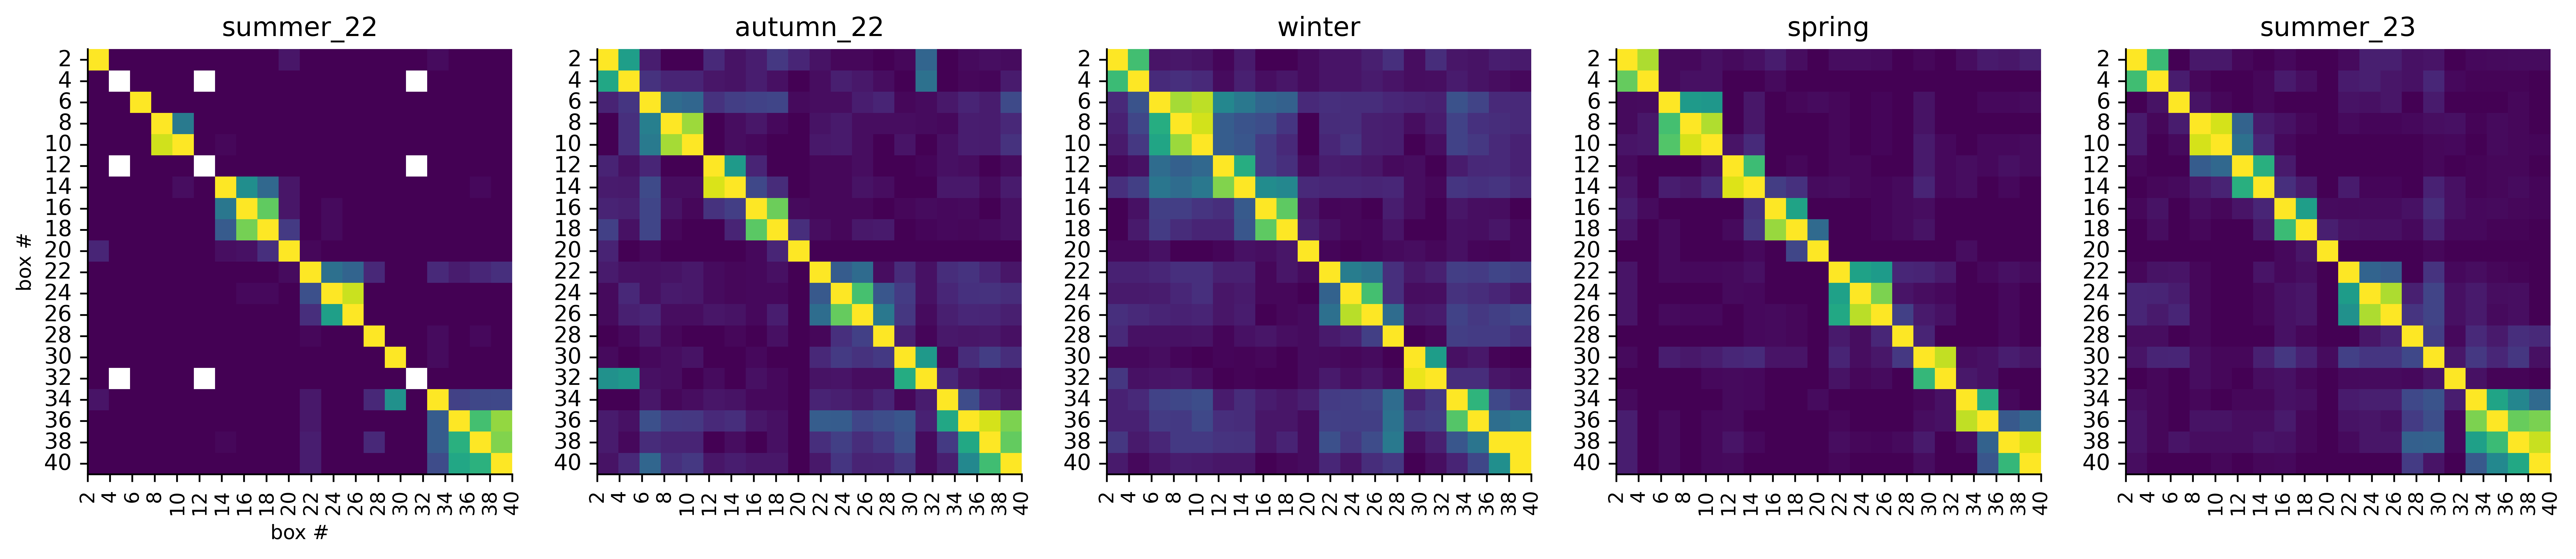

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize = [20,4], dpi = 600)

for season, ax in zip(['summer_22', 'autumn_22', 'winter', 'spring', 'summer_23'], axes):
    
    sns.heatmap(pd.DataFrame(overlap_matrix_22_23[season]), 
                square = True,
                cmap = 'viridis', 
                ax=ax, 
                cbar = False)
    
    ax.set_title(season)
    ax.set_xticks(np.linspace(0,20, 20))
    ax.set_xticklabels(np.arange(2,42,2), rotation=90, size=9)
    if season == 'summer_22':
        ax.set_ylabel('box #', fontsize = 9)
        ax.set_xlabel('box #', fontsize = 9)
    
    sns.despine()

## Generate networks for analyses in panels E-J

### Get social networks and partitions 2013-2024
This will take about 20 minutes.

In [13]:

#define seasons and years
seasons = ['summer', 'autumn', 'winter', 'spring']
season2023 = 'summer' # this is the only season to calculate when year == 2023
years = np.arange(2013,2024,1)

#initialize dictionaries
networks_dict = {} 
partitions_dict = {}
mouse_to_partition = {}
boxes_per_partition = {}
mice_per_partition = {}
partition_count = {}
modularity_dict = {}
avg_edge_weight_per_community = {}
avg_degree_per_community = {}
external_connections_per_community = {}
intercommunity_edges_count = {}
betweenness_centrality_dict = {}
unique_community_connections = {}
centrality_dict = {}

for year in years:
    mouse_to_partition[year] = {}
    print(year)
    next_year = year + 1 # to deal with winter
    
    networks_dict[year] = {} 
    partitions_dict[year] = {}
    boxes_per_partition[year] = {}
    mice_per_partition[year] = {}
    partition_count[year] = {}
    modularity_dict[year] = {}
    avg_edge_weight_per_community[year] = {}
    avg_degree_per_community[year] = {}
    external_connections_per_community[year] = {}
    intercommunity_edges_count[year] = {}
    betweenness_centrality_dict[year] = {}
    unique_community_connections[year] = {}
    centrality_dict[year] = {}
    
    for season in seasons:
        mouse_to_partition[year][season] = {}
        boxes_per_partition[year][season] = {}
        mice_per_partition[year][season] = {}
        partition_count[year][season] = {}
        modularity_dict[year][season] = {}
        avg_edge_weight_per_community[year][season] = {}
        avg_degree_per_community[year][season] = {}
        external_connections_per_community[year][season] = {}
        intercommunity_edges_count[year][season] = {}
        betweenness_centrality_dict[year][season] = {}
        unique_community_connections[year][season] = {}
        centrality_dict[year][season] = {}
        
        if (season == 'winter'): # note we have 2024 jan/feb data but will not analyse it here

            print('\t',season)
            
            #load the saved meets from this year and season (note "winter" of year n is Decemeber of year n plus Jan/Feb of year n+1)
            months = ['01', '02']
            meet_paths = glob.glob(os.path.join(all_rfid,  'mouse_meets',str(year)+'12'+'01*.feather'))
            stay_paths = glob.glob(os.path.join(all_rfid,  'mouse_stays',str(year)+'12'+'01*.feather'))
            for month in months:
                meet_paths.extend(glob.glob(os.path.join(all_rfid,  'mouse_meets',str(year+1)+month+'01*.feather')))
                stay_paths.extend(glob.glob(os.path.join(all_rfid,  'mouse_stays',str(year+1)+month+'01*.feather')))

            # get the mice who will contribute to the social network (the ones who met at least one other mouse)
            these_meets = pd.concat([pd.read_feather(i) for i in meet_paths])
            these_stays = pd.concat([pd.read_feather(i) for i in stay_paths])
            
            #ignore closed (odd) boxes if 2021 or later
            if year >=2021:
                these_meets = these_meets[~(these_meets['box'] % 2 != 0)]
                these_stays = these_stays[~(these_stays['box_number'] % 2 != 0)]
            
            # get the mice
            meets_mice = list(these_meets['id1'].unique()) + list(these_meets['id2'].unique()) #get the id's associated with each meeting mouse's stay
            stays_mice = list(these_stays['transponder_id'].unique())
            these_mice = list(set(meets_mice).intersection(stays_mice))

            #only keep mice where we have stay information
            these_meets = these_meets[(these_meets['id1'].isin(these_mice)) & (these_meets['id2'].isin(these_mice))]
            these_stays = these_stays[these_stays['transponder_id'].isin(these_mice)] #find these stays

        elif season == 'spring':
            print('\t',season)
            #load the saved meets from this year and season (note winter of year n is Decemeber of year n plus Jan/Feb of year n+1)
            months = ['03', '04', '05']
            meet_paths = []
            stay_paths = []
            for month in months:
                meet_paths.extend(glob.glob(os.path.join(all_rfid,  'mouse_meets',str(year)+month+'01*.feather')))
                stay_paths.extend(glob.glob(os.path.join(all_rfid,  'mouse_stays',str(year)+month+'01*.feather')))

            # get the mice who will contribute to the social network (the ones who met at least one other mouse)
            these_meets = pd.concat([pd.read_feather(i) for i in meet_paths])
            these_stays = pd.concat([pd.read_feather(i) for i in stay_paths])
            
            #ignore closed (odd) boxes if 2021 or later
            if year >=2021:
                these_meets = these_meets[~(these_meets['box'] % 2 != 0)]
                these_stays = these_stays[~(these_stays['box_number'] % 2 != 0)]
                
            # get the mice
            meets_mice = list(these_meets['id1'].unique()) + list(these_meets['id2'].unique()) #get the id's associated with each meeting mouse's stay
            stays_mice = list(these_stays['transponder_id'].unique())
            these_mice = list(set(meets_mice).intersection(stays_mice))

            #only keep mice where we have stay information
            these_meets = these_meets[(these_meets['id1'].isin(these_mice)) & (these_meets['id2'].isin(these_mice))]
            these_stays = these_stays[these_stays['transponder_id'].isin(these_mice)] #find these stays

        elif season == 'autumn':
            print('\t',season)
            #load the saved meets from this year and season (note winter of year n is Decemeber of year n plus Jan/Feb of year n+1)
            months = ['09', '10', '11']
            meet_paths = []
            stay_paths = []
            for month in months:
                meet_paths.extend(glob.glob(os.path.join(all_rfid,  'mouse_meets',str(year)+month+'01*.feather')))
                stay_paths.extend(glob.glob(os.path.join(all_rfid,  'mouse_stays',str(year)+month+'01*.feather')))

            # get the mice who will contribute to the social network (the ones who met at least one other mouse)
            these_meets = pd.concat([pd.read_feather(i) for i in meet_paths])
            these_stays = pd.concat([pd.read_feather(i) for i in stay_paths])
            
            #ignore closed (odd) boxes if 2021 or later
            if year >=2021:
                these_meets = these_meets[~(these_meets['box'] % 2 != 0)]
                these_stays = these_stays[~(these_stays['box_number'] % 2 != 0)]
            
            # get the mice
            meets_mice = list(these_meets['id1'].unique()) + list(these_meets['id2'].unique()) #get the id's associated with each meeting mouse's stay
            stays_mice = list(these_stays['transponder_id'].unique())
            these_mice = list(set(meets_mice).intersection(stays_mice))

            #only keep mice where we have stay information
            these_meets = these_meets[(these_meets['id1'].isin(these_mice)) & (these_meets['id2'].isin(these_mice))]
            these_stays = these_stays[these_stays['transponder_id'].isin(these_mice)] #find these stays

        elif season == 'summer':
            print('\t',season)
            #load the saved meets from this year and season (note winter of year n is Decemeber of year n plus Jan/Feb of year n+1)
            months = ['06', '07', '08']
            meet_paths = []
            stay_paths = []
            for month in months:
                meet_paths.extend(glob.glob(os.path.join(all_rfid,  'mouse_meets',str(year)+month+'01*.feather')))
                stay_paths.extend(glob.glob(os.path.join(all_rfid,  'mouse_stays',str(year)+month+'01*.feather')))

            # get the mice who will contribute to the social network (the ones who met at least one other mouse)
            these_meets = pd.concat([pd.read_feather(i) for i in meet_paths])
            these_stays = pd.concat([pd.read_feather(i) for i in stay_paths])
            
            #ignore closed (odd) boxes if 2021 or later
            if year >=2021:
                these_meets = these_meets[~(these_meets['box'] % 2 != 0)]
                these_stays = these_stays[~(these_stays['box_number'] % 2 != 0)]
            
            #get the mice
            meets_mice = list(these_meets['id1'].unique()) + list(these_meets['id2'].unique()) #get the id's associated with each meeting mouse's stay
            stays_mice = list(these_stays['transponder_id'].unique())
            these_mice = list(set(meets_mice).intersection(stays_mice))

            #only keep mice where we have stay information
            these_meets = these_meets[(these_meets['id1'].isin(these_mice)) & (these_meets['id2'].isin(these_mice))]
            these_stays = these_stays[these_stays['transponder_id'].isin(these_mice)] #find these stays

        #make sure there is data
        if (len(these_meets) > 0) & (len(these_stays) > 0):

            # make the graph
            graph = rfid.get_igraph_network(meets_df=these_meets, stays_df=these_stays, weight=True)
            G = graph.to_networkx() # convert to networkx for ease of use in python

            for idx in graph.vs.indices: #for each node
                for attr in graph.vs.attributes(): #port the attributes from igraph
                    G.nodes[idx][attr] = graph.vs[idx][attr]

            #rename the nodes
            rename_dict = {}
            for key in G.nodes():
                rename_dict[key] = G.nodes[key]['name']
                G = nx.relabel_nodes(G, rename_dict)

            #find clusters using Louvain algorithm
            partition = community.best_partition(G, random_state = 123456)
            
            # calculate modularity
            modularity = community.modularity(partition, G)

            #assign cluster identity as an attribute to each node
            for node_id, community_id in partition.items():
                G.nodes[node_id]['community_id'] = community_id          

            #add sex
            for idx, attributes in G.nodes(data=True): # add phenotypes from the phenotype table
                G.nodes[idx]['sex'] = sex_dict.get(attributes['name'], float('NaN'))
                
             # Calculate node betweenness centrality (using networkx)
            betweenness_centrality = nx.betweenness_centrality(G)

            #assign betweenness centrality to each node in the G graph
            for node_id, centrality in betweenness_centrality.items():
                G.nodes[node_id]['betweenness_centrality'] = centrality

            #calculate the number of unique communities each node connects to
            community_connections = {}
            for node_id in G.nodes:
                neighbors = list(G.neighbors(node_id))
                unique_communities = set(partition[n] for n in neighbors if n != node_id)
                community_connections[node_id] = len(unique_communities)

            #get node graph properties and make it an attribute
            degree_centrality = nx.centrality.degree_centrality(G)
            degree = {node: G.degree[node] for node in G.nodes}
            clustering_coefficients = {node: nx.clustering(G, node) for node in G.nodes}
            for idx, attributes in G.nodes(data=True):
                G.nodes[idx]['degree'] = degree[idx]
                G.nodes[idx]['centrality'] = degree_centrality[idx]
                G.nodes[idx]['clustering_coeff'] = clustering_coefficients[idx]
                
            #calculate average edge weight per community
            community_edge_weights = {c: [] for c in set(partition.values())}
            for (u, v, data) in G.edges(data=True):
                community_u = partition[u]
                community_v = partition[v]
                if community_u == community_v:
                    community_edge_weights[community_u].append(data['weight'])
            avg_edge_weight = {c: np.mean(weights) if weights else 0 for c, weights in community_edge_weights.items()}
            
            #calculate average degree per community
            community_degrees = {c: [] for c in set(partition.values())}
            for node in G.nodes:
                this_community = partition[node]
                community_degrees[this_community].append(G.degree[node])
            avg_degree = {c: np.mean(degrees) if degrees else 0 for c, degrees in community_degrees.items()}

            #get the number of boxes visited for each node using the stays table
            for node in G.nodes:
                G.nodes[node]['boxes_visited'] = these_stays[these_stays['transponder_id'] == node]['box_number'].nunique()
                
            #get number of clusters from best partition
            num_clusters = len(set(partition.values()))
            
            #get the number of unique boxes per cluster from the best partition
            unique_boxes_per_cluster = {c: these_stays[these_stays['transponder_id'].isin([n for n in partition if partition[n] == c])]['box_number'].to_list() for c in set(partition.values())}
            
            #get the number of mice per cluster from the best partition
            mice_per_cluster = {c: list(partition.values()).count(c) for c in set(partition.values())}
            
            #make a dictionary that maps mouse ID to partition from best partition
            for mouse in partition:
                mouse_to_partition[year][season][mouse] = partition[mouse]
                
            # Calculate the number of members of each community that have an edge with a node outside of the community
            external_connections = {c: 0 for c in set(partition.values())}
            community_edges = {c: set() for c in set(partition.values())}  # Use sets to track unique intercommunity connections
            for node in G.nodes:
                node_community = partition[node]
                for neighbor in G.neighbors(node):
                    neighbor_community = partition[neighbor]
                    if neighbor_community != node_community:
                        external_connections[node_community] += 1
                        community_edges[node_community].add(neighbor_community)  # Add unique connections to the set
            
            # Count the number of unique other communities each community is connected to
            intercommunity_count = {c: len(communities) for c, communities in community_edges.items()}

            #assign to dictionary
            networks_dict[year][season] = G
            partitions_dict[year][season] = partition
            boxes_per_partition[year][season] = unique_boxes_per_cluster
            mice_per_partition[year][season] = mice_per_cluster
            partition_count[year][season] = num_clusters
            modularity_dict[year][season] = modularity
            avg_edge_weight_per_community[year][season] = avg_edge_weight
            avg_degree_per_community[year][season] = avg_degree
            external_connections_per_community[year][season] = external_connections
            intercommunity_edges_count[year][season] = intercommunity_count
            betweenness_centrality_dict[year][season] = betweenness_centrality
            unique_community_connections[year][season] = community_connections
            centrality_dict[year][season] = degree_centrality

        else:
            print(season, 'in', year, 'has no meets or stays...')
            networks_dict[year][season] = None
            partitions_dict[year][season] = None
            boxes_per_partition[year][season] = None
            mice_per_partition[year][season] = None
            partition_count[year][season] = None
            modularity_dict[year][season] = None
            avg_edge_weight_per_community[year][season] = None
            avg_degree_per_community[year][season] = None
            external_connections_per_community[year][season] = None
            intercommunity_edges_count[year][season] = None
            betweenness_centrality_dict[year][season] = None
            unique_community_connections[year][season] = None
            centrality_dict[year][season] = None

print('done.')

2013
	 summer
summer in 2013 has no meets or stays...
	 autumn


/var/folders/h6/6fyt3jld5pq_w03ql1jw0gnh0000gn/T/ipykernel_7542/4029204704.py:124: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  these_meets = pd.concat([pd.read_feather(i) for i in meet_paths])
/var/folders/h6/6fyt3jld5pq_w03ql1jw0gnh0000gn/T/ipykernel_7542/4029204704.py:125: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  these_stays = pd.concat([pd.read_feather(i) for i in stay_paths])


	 winter
	 spring


/var/folders/h6/6fyt3jld5pq_w03ql1jw0gnh0000gn/T/ipykernel_7542/4029204704.py:96: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  these_meets = pd.concat([pd.read_feather(i) for i in meet_paths])
/var/folders/h6/6fyt3jld5pq_w03ql1jw0gnh0000gn/T/ipykernel_7542/4029204704.py:97: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  these_stays = pd.concat([pd.read_feather(i) for i in stay_paths])


2014
	 summer
	 autumn
	 winter
	 spring
2015
	 summer
	 autumn
	 winter
	 spring
2016
	 summer
	 autumn
	 winter
	 spring
2017
	 summer
	 autumn
	 winter
	 spring
2018
	 summer
	 autumn
	 winter
	 spring
2019
	 summer
	 autumn
	 winter
	 spring
2020
	 summer
	 autumn
	 winter
	 spring
2021
	 summer
	 autumn
	 winter
	 spring
2022
	 summer
	 autumn
	 winter
	 spring


/var/folders/h6/6fyt3jld5pq_w03ql1jw0gnh0000gn/T/ipykernel_7542/4029204704.py:96: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  these_meets = pd.concat([pd.read_feather(i) for i in meet_paths])


2023
	 summer
	 autumn
	 winter
	 spring
done.


In [14]:
these_stays

,level_0,id,entry_time,exit_time,entry_id,exit_id,time_in_secs,transponder_id,box_number
0,0,84578772,2023-02-28 18:03:54.580,2023-03-01 07:17:04.721,111290287,111305116,47590.141,6439,24
1,1,84584979,2023-02-28 18:09:01.234,2023-03-01 06:21:29.105,111302047,111317783,43947.871,6842,20
2,2,84578444,2023-02-28 18:10:16.944,2023-03-01 02:37:05.640,111289494,111304439,30408.696,5441,38
3,3,84579473,2023-02-28 18:15:40.059,2023-03-01 12:49:51.234,111291386,111306557,66851.175,6196,22
4,4,84583176,2023-02-28 18:17:08.562,2023-03-01 00:59:20.406,111298793,111314096,24131.844,6521,38
...,...,...,...,...,...,...,...,...,...
136510,136530,85346831,2023-05-31 23:59:07.378,2023-06-01 01:59:07.968,112853414,112863745,7200.590,5788,4
136511,136531,85348670,2023-05-31 23:59:07.579,2023-06-01 00:11:38.811,112859215,112867464,751.232,6098,30
136512,136532,85349574,2023-05-31 23:59:18.538,2023-06-01 00:20:22.867,112861119,112869297,1264.329,6857,10
136513,136533,85348085,2023-05-31 23:59:32.209,2023-06-01 00:07:03.180,112857254,112866286,450.971,6007,28


In [15]:
year =2021
season = 'summer'
for i in boxes_per_partition[year][season]:
    print('cluster', i, ':', set(boxes_per_partition[year][season][i]))

cluster 0 : {36, 18, 22, 24, 26, 28}
cluster 1 : {36, 6, 8, 10, 14}
cluster 2 : {8, 26, 6, 22}
cluster 3 : {18, 20, 14}
cluster 4 : {36, 6, 40, 10, 14, 20, 22, 24, 26, 28}
cluster 5 : {30}
cluster 6 : {32, 34, 36, 14, 20, 24, 28, 30}
cluster 7 : {34, 36, 38, 40, 14, 22, 24, 26, 30}
cluster 8 : {6, 8, 10, 14, 18}
cluster 9 : {36, 8, 10, 12, 14, 22}
cluster 10 : {32, 14, 38, 30}
cluster 11 : {18}
cluster 12 : {2, 36, 6, 8, 14, 26}
cluster 13 : {34, 36, 38, 8, 14, 20, 24, 26, 28, 30}
cluster 14 : {20, 14}
cluster 15 : {36, 38, 40, 8, 22, 26, 28}


### Iterate through seasonal graphs and test hypothesis that there is community structure
This will take about twenty minutes.

In [16]:
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities
import numpy as np
from scipy.stats import norm
import concurrent.futures

years = range(2013, 2024)
seasons = ['autumn', 'winter', 'spring', 'summer']
num_null_models = 100  # Number of null hypothesis networks to generate

modularity_results = {}

def calculate_null_modularity(G):
    
    #generate a random network network with the same size and degree distribution as G
    G_null = nx.configuration_model([d for n, d in G.degree()])
    G_null = nx.Graph(G_null)  # Convert to simple graph
    G_null.remove_edges_from(nx.selfloop_edges(G_null))  # Remove self-loops

    #calculate its modularity
    null_partition = community.best_partition(G_null)
    null_modularity = community.modularity(null_partition, G_null)
    return null_modularity

for year in years:
    print(year)
    modularity_results[year] = {}
    
    for season in seasons:
        
        print('\t', season)
        
        if year in networks_dict and season in networks_dict[year]:
           

            # Get the modularity you just calculated
            modularity_original = modularity_dict[year][season]
            
            if not modularity_original is None:
                
                 # Extract the original network
                G = networks_dict[year][season]

                # Generate null model networks and calculate their modularity
                null_modularities = []

                for _ in tqdm(range(num_null_models)):
                    null_modularity = calculate_null_modularity(G)
                    null_modularities.append(null_modularity)

                # Calculate the mean and standard deviation of the null model modularities
                mu_null = np.mean(null_modularities)
                sigma_null = np.std(null_modularities)

                # Calculate the Z-score
                z_score = (modularity_original - mu_null) / sigma_null

                # Calculate the p-valye
                p_value = norm.sf(abs(z_score)) * 2  # two-tailed test

                modularity_results[year][season] = {
                    'modularity_original': modularity_original,
                    'mu_null': mu_null,
                    'sigma_null': sigma_null,
                    'z_score': z_score,
                    'p-value':p_value,
                    'null_modularities': null_modularities
                }


2013
	 autumn


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.42it/s]


	 winter


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.47it/s]


	 spring


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 23.48it/s]


	 summer
2014
	 autumn


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:11<00:00,  9.03it/s]


	 winter


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.86it/s]


	 spring


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.92it/s]


	 summer


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.63it/s]


2015
	 autumn


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.37it/s]


	 winter


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.05it/s]


	 spring


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.90it/s]


	 summer


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.29it/s]


2016
	 autumn


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:40<00:00,  2.45it/s]


	 winter


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:30<00:00,  3.23it/s]


	 spring


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.55it/s]


	 summer


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.42it/s]


2017
	 autumn


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.04it/s]


	 winter


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.12it/s]


	 spring


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:23<00:00,  4.34it/s]


	 summer


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.55it/s]


2018
	 autumn


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.43it/s]


	 winter


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:36<00:00,  2.70it/s]


	 spring


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.79it/s]


	 summer


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.70it/s]


2019
	 autumn


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:27<00:00,  3.59it/s]


	 winter


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:23<00:00,  4.26it/s]


	 spring


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.63it/s]


	 summer


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:25<00:00,  3.86it/s]


2020
	 autumn


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:32<00:00,  3.05it/s]


	 winter


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.82it/s]


	 spring


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  5.92it/s]


	 summer


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:36<00:00,  2.74it/s]


2021
	 autumn


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 34.08it/s]


	 winter


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 244.06it/s]


	 spring


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.30it/s]


	 summer


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.31it/s]


2022
	 autumn


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.84it/s]


	 winter


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.00it/s]


	 spring


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 84.69it/s]


	 summer


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.88it/s]


2023
	 autumn


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:22<00:00,  4.51it/s]


	 winter


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 99.06it/s]


	 spring


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.43it/s]


	 summer


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.71it/s]


### Make a df of modularities

In [17]:
# Initialize an empty list to store flattened results
flat_results = []

# Flatten the nested dictionary into a list of dictionaries
for year in modularity_results:
    for season in modularity_results[year]:
        data = modularity_results[year][season]
        flat_results.append({
            'year': year,
            'season': season,
            'modularity_original': data['modularity_original'],
            'mu_null': data['mu_null'],
            'sigma_null': data['sigma_null'],
            'Z_score': data['z_score'],
            'p_value': data['p-value'],
            'null_modularities': data['null_modularities']
        })

# Create a DataFrame from the flattened results
modularities_df = pd.DataFrame(flat_results)


### Iterate through seasonal graphs and test hypothesis that graphs have "small world" properties

In [18]:
# import networkx as nx
# import numpy as np
# from tqdm import tqdm
# import concurrent.futures

# years = range(2013, 2024)
# seasons = ['autumn', 'winter', 'spring', 'summer']
# num_null_models = 100  # Number of null hypothesis networks to generate

# small_world_results = {}

# def calculate_null_small_world_metrics(G):
#     # Generate a configuration model network
#     G_null = nx.configuration_model([d for n, d in G.degree()])
#     G_null = nx.Graph(G_null)  # Convert to simple graph
#     G_null.remove_edges_from(nx.selfloop_edges(G_null))  # Remove self-loops

#     # Calculate the clustering coefficient and average shortest path length of the null model network
#     clustering_coeff_null = nx.average_clustering(G_null)
#     try:
#         avg_shortest_path_length_null = nx.average_shortest_path_length(G_null)
#     except nx.NetworkXError:  # Handle disconnected graphs
#         avg_shortest_path_length_null = float('inf')
    
#     return clustering_coeff_null, avg_shortest_path_length_null

# for year in years:
#     print(year)
#     small_world_results[year] = {}
    
#     for season in seasons:
        
#         print('\t', season)
        
#         if year in networks_dict and season in networks_dict[year]:

#             # Extract the original network
#             G = networks_dict[year][season]
            
#             if G is not None:
#                 # Calculate the clustering coefficient and average shortest path length of the original graph
#                 clustering_coeff_original = nx.average_clustering(G)
#                 try:
#                     avg_shortest_path_length_original = nx.average_shortest_path_length(G)
#                 except nx.NetworkXError:  # Handle disconnected graphs
#                     avg_shortest_path_length_original = float('inf')
                
#                 # Generate null model networks and calculate their metrics
#                 null_clustering_coeffs = []
#                 null_avg_shortest_path_lengths = []

#                 for _ in tqdm(range(num_null_models)):
#                     clustering_coeff_null, avg_shortest_path_length_null = calculate_null_small_world_metrics(G)
#                     null_clustering_coeffs.append(clustering_coeff_null)
#                     null_avg_shortest_path_lengths.append(avg_shortest_path_length_null)

#                 # Calculate the mean and standard deviation of the null model metrics
#                 mu_clustering_coeff_null = np.mean(null_clustering_coeffs)
#                 sigma_clustering_coeff_null = np.std(null_clustering_coeffs)
#                 mu_avg_shortest_path_length_null = np.mean(null_avg_shortest_path_lengths)
#                 sigma_avg_shortest_path_length_null = np.std(null_avg_shortest_path_lengths)

#                 # Calculate the small-world coefficient
#                 sigma = (clustering_coeff_original / mu_clustering_coeff_null) / (avg_shortest_path_length_original / mu_avg_shortest_path_length_null)

#                 small_world_results[year][season] = {
#                     'clustering_coeff_original': clustering_coeff_original,
#                     'avg_shortest_path_length_original': avg_shortest_path_length_original,
#                     'mu_clustering_coeff_null': mu_clustering_coeff_null,
#                     'sigma_clustering_coeff_null': sigma_clustering_coeff_null,
#                     'mu_avg_shortest_path_length_null': mu_avg_shortest_path_length_null,
#                     'sigma_avg_shortest_path_length_null': sigma_avg_shortest_path_length_null,
#                     'sigma': sigma,
#                     'null_clustering_coeffs': null_clustering_coeffs,
#                     'null_avg_shortest_path_lengths': null_avg_shortest_path_lengths
#                 }
#             else:
#                 small_world_results[year][season] = None




In [19]:
# # Display results
# for year in small_world_results:
#     for season in small_world_results[year]:
#         if small_world_results[year][season] is not None:
#             print(f'Year: {year}, Season: {season}')
#             print(f"  Small-world coefficient (sigma): {small_world_results[year][season]['sigma']:.4f}")

### Make a df of small world coefficients

In [20]:
# import pandas as pd

# # Initialize a list to store flattened results
# flat_results = []

# # Iterate over the dictionary to flatten it
# for year in small_world_results:
#     for season in small_world_results[year]:
        
#         data = small_world_results[year][season]
        
#         if not data is None:
#             flat_results.append({
#                 'year': year,
#                 'season': season,
#                 'clustering_coeff_original': data['clustering_coeff_original'],
#                 'avg_shortest_path_length_original': data['avg_shortest_path_length_original'],
#                 'mu_clustering_coeff_null': data['mu_clustering_coeff_null'],
#                 'sigma_clustering_coeff_null': data['sigma_clustering_coeff_null'],
#                 'mu_avg_shortest_path_length_null': data['mu_avg_shortest_path_length_null'],
#                 'sigma_avg_shortest_path_length_null': data['sigma_avg_shortest_path_length_null'],
#                 'sigma': data['sigma'],
#                 'null_clustering_coeffs': data['null_clustering_coeffs'],
#                 'null_avg_shortest_path_lengths': data['null_avg_shortest_path_lengths']
#             })

# # Create a DataFrame from the flattened results
# small_world_df = pd.DataFrame(flat_results)



## Collect metadata for analyses in panels E-J

### Get mice per social network community

In [21]:
# Initialize an empty list to collect rows of data
mice_per_cluster_data = []

# Iterate over the years and seasons in mice_per_cluster_dict
for year in mice_per_partition:
    for season in mice_per_partition[year]:
        if mice_per_partition[year][season] is not None:
            for cluster, mice_count in mice_per_partition[year][season].items():
                # Append a row to the list
                mice_per_cluster_data.append([year, season, cluster, mice_count])

                
# Convert the list of rows into a DataFrame
social_network_metadata = pd.DataFrame(mice_per_cluster_data, columns=['Year', 'Season', 'Cluster', 'Mice_Count'])
total_mice_df = social_network_metadata.groupby(['Year', 'Season']).agg(population_size=('Mice_Count', 'sum')).reset_index()
social_network_metadata = social_network_metadata.merge(total_mice_df, how = 'left')
social_network_metadata['percent_total_population'] = social_network_metadata['Mice_Count']/social_network_metadata['population_size']



### Add edge weight and degree 

In [22]:
# Initialize an empty list to collect rows of data
avg_edge_weight_data = []
avg_degree_data = []

# Iterate over the years and seasons in mice_per_cluster_dict
for year in avg_edge_weight_per_community:
    for season in avg_edge_weight_per_community[year]:
        if avg_edge_weight_per_community[year][season] is not None:
            for cluster, weight in avg_edge_weight_per_community[year][season].items():
                # Append a row to the list
                avg_edge_weight_data.append([year, season, cluster, weight])
            for cluster, degree in avg_degree_per_community[year][season].items():
                # Append a row to the list
                avg_degree_data.append([year, season, cluster, degree])
            intercommunity_edges_count

                
# Convert the list of rows into a DataFrame
edge_weight_per_cluster_df = pd.DataFrame(avg_edge_weight_data, columns=['Year', 'Season', 'Cluster', 'edge_weight'])
avg_degree_per_cluster_df = pd.DataFrame(avg_degree_data, columns=['Year', 'Season', 'Cluster', 'avg_degree'])
social_network_metadata = edge_weight_per_cluster_df.merge(social_network_metadata, how = 'left')
social_network_metadata = avg_degree_per_cluster_df.merge(social_network_metadata, how = 'left')
social_network_metadata['percent_total_population'] = social_network_metadata['Mice_Count']/social_network_metadata['population_size']
social_network_metadata['edge_weight_per_community_size'] = social_network_metadata['edge_weight']/social_network_metadata['Mice_Count']
social_network_metadata['avg_degree_per_community_size'] = social_network_metadata['avg_degree']/social_network_metadata['Mice_Count']


### Calculate boxes per social network community

In [23]:
# Initialize an empty list to collect rows of data
mice_per_cluster_data = []

# Iterate over the years and seasons in mice_per_cluster_dict
for year in boxes_per_partition:
    
    for season in boxes_per_partition[year]:
        
        if boxes_per_partition[year][season] is not None:
            
            for cluster, box_count in boxes_per_partition[year][season].items():
                
                # Append a row to the list
                mice_per_cluster_data.append([year, season, cluster, box_count])

# convert the list of rows into a DataFrame
boxes_per_cluster_df = pd.DataFrame(mice_per_cluster_data, columns=['year', 'season', 'cluster', 'boxes_occupied'])

# count the boxes
boxes_per_cluster_df['num_boxes_occupied'] = boxes_per_cluster_df['boxes_occupied'].apply(lambda x: len(set(ast.literal_eval(str(x)))))

# add a column for % boxes occupied 
# NB pre-2021, there are 40 total boxes. From 2021 onward there are 20
boxes_per_cluster_df['percent_boxes_occupied'] = boxes_per_cluster_df.apply(
    lambda row: row['num_boxes_occupied'] / (20 if row['year'] >= 2021 else 40),
    axis=1
)


In [24]:
boxes_per_cluster_df

,year,season,cluster,boxes_occupied,num_boxes_occupied,percent_boxes_occupied
0,2013,autumn,0,"[25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 2...",19,0.475
1,2013,autumn,1,"[22, 22, 22, 22, 23, 22, 22, 22, 22, 22, 22, 2...",7,0.175
2,2013,autumn,2,"[40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 4...",29,0.725
3,2013,autumn,3,"[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, ...",4,0.100
4,2013,autumn,4,"[1, 1, 3, 3, 3, 3, 4, 3, 4, 1, 1, 3, 1, 4, 3, ...",5,0.125
...,...,...,...,...,...,...
649,2023,spring,7,"[16, 16, 16, 16, 16, 16, 18, 16, 18, 16, 18, 1...",9,0.450
650,2023,spring,8,"[22, 22, 22, 22, 22, 22, 26, 22, 22, 22, 22, 2...",9,0.450
651,2023,spring,9,"[28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 2...",5,0.250
652,2023,spring,10,"[2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 4, ...",6,0.300


### Count clusters

In [25]:
num_clusters_data = []

# Iterate over the years and seasons in mice_per_cluster_dict
for year in partition_count:
    for season in partition_count[year]:
        if partition_count[year][season] is not None:
                num_clusters = partition_count[year][season]
                num_clusters_data.append([year, season, num_clusters])

# Convert the list of rows into a DataFrame
num_clusters_df = pd.DataFrame(num_clusters_data, columns=['year', 'season', 'Num_Clusters'])

### Count community connections per cluster

In [26]:

# Initialize an empty list to collect rows of data
community_connections_data = []

# Iterate over the years and seasons in mice_per_cluster_dict
for year in betweenness_centrality_dict:
    for season in betweenness_centrality_dict[year]:
        if (unique_community_connections[year][season] is not None):
            for mouse, connections in unique_community_connections[year][season].items():
                # Append a row to the list
                community_connections_data.append([year, season, mouse, connections])

# Convert the list of rows into a DataFrame
community_connections_df = pd.DataFrame(community_connections_data, columns=['year', 'season', 'mouse', 'community_connections'])
community_connections_df = num_clusters_df.merge(community_connections_df, on = ['year', 'season'])
community_connections_df['sex'] = community_connections_df['mouse'].astype(int).map(sex_dict)
community_connections_df['percent_communities_connected'] = community_connections_df['community_connections']/community_connections_df['Num_Clusters']

### Calculate node centrality

In [27]:
# Initialize an empty list to collect rows of data
centrality_data = []

# Iterate over the years and seasons in mice_per_cluster_dict
for year in centrality_dict:
    for season in centrality_dict[year]:
        if (centrality_dict[year][season] is not None):
            for mouse, centrality in centrality_dict[year][season].items():
                # Append a row to the list
                centrality_data.append([year, season, mouse, centrality])

# Convert the list of rows into a DataFrame
centrality_df = pd.DataFrame(centrality_data, columns=['year', 'season', 'mouse', 'centrality'])
centrality_df['sex'] = centrality_df['mouse'].astype(int).map(sex_dict)

### Calculate betweeness centrality

In [28]:
# Initialize an empty list to collect rows of data
betweenness_centrality_data = []

# Iterate over the years and seasons in mice_per_cluster_dict
for year in betweenness_centrality_dict:
    for season in betweenness_centrality_dict[year]:
        if (betweenness_centrality_dict[year][season] is not None):
            for mouse, bw_centrality in betweenness_centrality_dict[year][season].items():
                # Append a row to the list
                betweenness_centrality_data.append([year, season, mouse, bw_centrality])

# Convert the list of rows into a DataFrame
betweeness_centrality_df = pd.DataFrame(betweenness_centrality_data, columns=['year', 'season', 'mouse', 'betweeness_centrality'])
betweeness_centrality_df['sex'] = betweeness_centrality_df['mouse'].astype(int).map(sex_dict)

### Count intercommunity connections

In [29]:
# Initialize an empty list to collect rows of data
inter_community_connections_data = []

# Iterate over the years and seasons in mice_per_cluster_dict
for year in boxes_per_partition:
    for season in boxes_per_partition[year]:
        if boxes_per_partition[year][season] is not None:
            for cluster, inter_community_connections in intercommunity_edges_count[year][season].items():
                # Append a row to the list
                inter_community_connections_data.append([year, season, cluster, inter_community_connections])

# Convert the list of rows into a DataFrame
inter_community_connections_df = pd.DataFrame(inter_community_connections_data, columns=['Year', 'Season', 'Cluster', 'Inter_Community_Connections'])


### Calculate modularity

In [30]:
# Initialize an empty list to collect rows of data
modularity_data = []

# Iterate over the years and seasons in mice_per_cluster_dict
for year in boxes_per_partition:
    for season in boxes_per_partition[year]:
        if modularity_dict[year][season] is not None:
            modularity = modularity_dict[year][season]
            modularity_data.append([year, season, cluster, modularity])

# Convert the list of rows into a DataFrame
modularity_per_cluster_df = pd.DataFrame(modularity_data, columns=['year', 'season', 'cluster', 'modularity'])
avg_modularity_per_cluster_df = modularity_per_cluster_df.groupby(['year', 'season']).agg(avg_modularity=('modularity', 'mean')).reset_index()
#modularity_per_cluster_df = modularity_per_cluster_df[modularity_per_cluster_df['year'] != 2021]

### Get weekly box turnover
This will take ~20 hours to run - I recommend saving the output to a csv

In [31]:
# weeks_list = []
# id_list = []
# occupants_this_week_list = []
# occupants_last_week_list = []
# num_occupants_this_week_list = []
# num_occupants_last_week_list = []
# still_occupants_list = []
# occupants_overlap_list = []
# start_date = pd.to_datetime('2013-01-01 00:00:00')
# end_date = pd.to_datetime('2023-08-31 00:00:00')
# weeks = pd.Series(pd.date_range(start=start_date, end=end_date, freq='W')).dt.to_period('W')
# coi_list = []
# boxes_list = []
# done = []

# #for each box
# for box in np.arange(1,41,1):
#     print(box)

#     # for each week
#     for idx, week in tqdm(enumerate(weeks[1:], start = 1)):
        
#         # get the mice who used any box this week
#         this_week = stays[(stays['entry_time'] >= week.start_time) 
#                               & (stays['entry_time'] <= week.end_time)]

#         # if the box was used this week
#         if box in this_week['box'].unique():

#             #find mice who used the box this week
#             this_week = stays[(stays['entry_time'] >= week.start_time) 
#                               & (stays['entry_time'] <= week.end_time) 
#                               & (stays['box'] == box) ]
#             occupants_this_week = this_week['transponder_id'].unique()

#             #find the mice who used the box last week
#             last_week = stays[(stays['entry_time'] >= weeks[idx - 1].start_time) 
#                               & (stays['entry_time'] <= weeks[idx - 1].end_time) 
#                               & (stays['box'] == box)]
#             occupants_last_week = last_week['transponder_id'].unique()
            
#             # find the mice using the box this week that also used it last week
#             still_occupants = [i for i in occupants_this_week if i in occupants_last_week]

#             # if there were occupants last week, overlap = # still occupants this week/# occupants last week
#             if len(occupants_last_week) != 0:
#                 overlap = len(still_occupants)/len(occupants_last_week)
#             else:
#                 overlap = float('NaN')

#             #append to lists
#             weeks_list.append(week.start_time)
#             occupants_this_week_list.append(occupants_this_week)
#             occupants_last_week_list.append(occupants_last_week)
#             num_occupants_this_week_list.append(len(occupants_this_week))
#             num_occupants_last_week_list.append(len(occupants_last_week))
#             still_occupants_list.append(still_occupants)
#             occupants_overlap_list.append(overlap)
#             boxes_list.append(box)
#             done.append(box)

In [33]:
temporary_tables = '/Volumes/LaCie_barn/mouse_barn_audiomoth/results/Figures/Figure_2/temporary_tables'
turnover_df = pd.read_csv(os.path.join(temporary_tables,'weekly_turnover', 'turnover_from_allstays.csv'))

# #make a dataframe from the lists you just generated
# turnover_df = pd.DataFrame({
#     'box': boxes_list,
#     'week': weeks_list,
#     'occupants_this_week': occupants_this_week_list,
#     'occupants_last_week': occupants_last_week_list,
#     'num_occupants_this_week': num_occupants_this_week_list,
#     'num_occupants_last_week': num_occupants_last_week_list,
#     'still_occupants':still_occupants_list,
#     'occupants_overlap': occupants_overlap_list

# })

# # add useful metadata and aggregare by year, season, and box
# turnover_df['week'] = pd.to_datetime(turnover_df['week'])
# turnover_df['turnover'] = 1 - turnover_df['occupants_overlap']
# turnover_df['year'] = turnover_df['week'].dt.year
# turnover_df['month'] = turnover_df['week'].dt.month
# turnover_df['season'] = ['summer' if month in [6,7,8] else
#                            'autumn' if month in [9, 10, 11] else
#                            'winter' if month in [12,1,2] else 'spring' for month in turnover_df['month']]
# agg_turnover_df = turnover_df.groupby(['year', 'season', 'box']).agg(avg_seasonal_turnover=('turnover','mean')).reset_index()
# # agg_turnover_df = agg_turnover_df[~agg_turnover_df['year'].isin([2021])] # remove the year of the population crash because there is unusually high turnover in this year

# #save it so you don't have to run again
# #turnover_df.to_csv('')


### Get mice per box by year and season

In [34]:
average_num_mice_per_box_by_year_season = box_events.groupby(['year', 'season', 'box']).agg(average_num_mice_per_box=('occupancy_after_event', 'median')).reset_index()

## Get inter-box distances

### Get the distances

In [35]:
box_coords_df = pd.read_csv(os.path.join(root, 'parameters', 'barn_layout','boxpos.csv'))
box_coords_dict = {}
for box in list(box_coords_df['box'].unique()):
    (x,y) = (box_coords_df['x'][box_coords_df['box'] == box].iloc[0], box_coords_df['y'][box_coords_df['box'] == box].iloc[0])
    box_coords_dict[box] = (x,y)
    
box_names = list(box_coords_dict.keys())
coords = np.array(list(box_coords_dict.values()))
df_coords = pd.DataFrame(coords, index=box_names, columns=['x', 'y'])

# Calculate the Euclidean distance between each pair of boxes
interbox_distance_matrix = pd.DataFrame(np.zeros((len(df_coords), len(df_coords))), index=box_names, columns=box_names)

# Calculate the Euclidean distance between each pair of boxes
for i, (box1, coord1) in enumerate(df_coords.iterrows()):
    for j, (box2, coord2) in enumerate(df_coords.iterrows()):
        distance = np.sqrt((coord1['x'] - coord2['x'])**2 + (coord1['y'] - coord2['y'])**2)
        interbox_distance_matrix.loc[box1, box2] = distance

### Get mice shared by boxes for all seasons
This will take about 3 minutes

In [36]:
years = np.arange(2013,2024,1)
seasons = ['summer', 'autumn', 'winter', 'spring']

# Initialize the dictionary to store heatmaps
heatmaps_dict = {}

# Iterate through each year
for year in years:
    print(year)
    next_year = year + 1  # to deal with winter

    heatmaps_dict[year] = {}

    for season in seasons:
        print('\t', season)

        # Load the saved stays from this year and season
        if season == 'winter':
            months = ['12', '01', '02']
            stay_paths = glob.glob(os.path.join(all_rfid, 'mouse_stays', f'{year}12' + '01*.feather'))
            for month in ['01', '02']:
                stay_paths.extend(glob.glob(os.path.join(all_rfid, 'mouse_stays', f'{next_year}{month}' + '01*.feather')))
        elif season == 'spring':
            months = ['03', '04', '05']
            stay_paths = []
            for month in months:
                stay_paths.extend(glob.glob(os.path.join(all_rfid, 'mouse_stays', f'{year}{month}' + '01*.feather')))
        elif season == 'summer':
            months = ['06', '07', '08']
            stay_paths = []
            for month in months:
                stay_paths.extend(glob.glob(os.path.join(all_rfid, 'mouse_stays', f'{year}{month}' + '01*.feather')))
        elif season == 'autumn':
            months = ['09', '10', '11']
            stay_paths = []
            for month in months:
                stay_paths.extend(glob.glob(os.path.join(all_rfid, 'mouse_stays', f'{year}{month}' + '01*.feather')))

        these_stays = pd.concat([pd.read_feather(path) for path in stay_paths])
        these_stays = these_stays[~((these_stays['box_number'] % 2 != 0) & (year >= 2021))]
        subset=['id', 'entry_time', 'exit_time', 'transponder_id', 'time_in_secs', 'entry_id', 'exit_id']
        these_stays = these_stays.drop_duplicates(subset=subset) # drop any duplicates
        
        stays_mice = these_stays['transponder_id'].unique()

        # Compute the overlap matrix
        overlap_matrix = {}
        these_stays = these_stays[these_stays['transponder_id'].isin(stays_mice)]

        # Correctly construct the mice_per_box dictionary outside the loop
        mice_per_box = {box: set(these_stays['transponder_id'][these_stays['box_number'] == box]) for box in np.arange(1, 41, 1)}
        for box_1 in np.arange(1, 41, 1):
            if box_1 in mice_per_box.keys():
                
                overlap_matrix[box_1] = {}
                box_1_mice = mice_per_box[box_1]

            for box_2 in np.arange(1, 41, 1):
                if box_2 in mice_per_box.keys():
                    box_2_mice = mice_per_box[box_2]

                    if len(box_1_mice) != 0:
                        overlap_matrix[box_1][box_2] = len(box_1_mice & box_2_mice) / len(box_1_mice)
                    else:
                        overlap_matrix[box_1][box_2] = 0

        overlap_df = pd.DataFrame(overlap_matrix)
        overlap_df.index = np.arange(1, 41, 1)

        # Store the overlap_df in the dictionary
        heatmaps_dict[year][season] = overlap_df

2013
	 summer
	 autumn


/var/folders/h6/6fyt3jld5pq_w03ql1jw0gnh0000gn/T/ipykernel_7542/2506993623.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  these_stays = pd.concat([pd.read_feather(path) for path in stay_paths])


	 winter
	 spring


/var/folders/h6/6fyt3jld5pq_w03ql1jw0gnh0000gn/T/ipykernel_7542/2506993623.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  these_stays = pd.concat([pd.read_feather(path) for path in stay_paths])


2014
	 summer
	 autumn
	 winter
	 spring
2015
	 summer
	 autumn
	 winter
	 spring
2016
	 summer
	 autumn
	 winter
	 spring
2017
	 summer
	 autumn
	 winter
	 spring
2018
	 summer
	 autumn
	 winter
	 spring
2019
	 summer
	 autumn
	 winter
	 spring
2020
	 summer
	 autumn
	 winter
	 spring
2021
	 summer
	 autumn
	 winter
	 spring
2022
	 summer
	 autumn
	 winter
	 spring
2023
	 summer
	 autumn
	 winter
	 spring


In [37]:
#make a dataframe from the interbox distances

longform_interbox_distances_df = plot.convert_interbox_values_to_longform(interbox_distance_matrix, value_name='distance')
all_mouse_shared_matrix_longform = []
years = np.arange(2013,2024,1)
seasons = ['summer', 'autumn', 'winter', 'spring']

# get mice shared between boxes 
for year in years:
    for season in seasons:
        
        mouse_shared_matrix = heatmaps_dict[year][season]
        mouse_shared_matrix_longform = plot.convert_interbox_values_to_longform(mouse_shared_matrix , value_name='fraction_mice_shared')
        mouse_shared_matrix_longform['year'] = year
        mouse_shared_matrix_longform['season'] = season
        all_mouse_shared_matrix_longform.append(mouse_shared_matrix_longform)

# combine all of the data and group by box pair
all_mice_shared_df = pd.concat(all_mouse_shared_matrix_longform)
all_mice_shared_df = all_mice_shared_df.merge(longform_interbox_distances_df, 
                                              on = ['box_1', 'box_2'], how = 'left')
all_mice_shared_df['box_pair'] = [f"{box_1}-{box_2}" for box_1, box_2 in zip(all_mice_shared_df['box_1'], all_mice_shared_df['box_2'])]
all_mice_shared_df_grouped = all_mice_shared_df.groupby(['season', 'box_pair']).agg({'fraction_mice_shared':'median', 
                                                                       'distance':'first', 
                                                                                     'box_1':'first', 'box_2':'first'}).reset_index()
all_mice_shared_df_2022_2023 = all_mice_shared_df[all_mice_shared_df['year'].isin([2022,2023])]
all_mice_shared_df_2022_2023_grouped = all_mice_shared_df_2022_2023.groupby(['season', 'box_pair']).agg({'fraction_mice_shared':'median', 
                                                                       'distance':'first', 
                                                                                     'box_1':'first', 'box_2':'first'}).reset_index()

# Make the Figure

/var/folders/h6/6fyt3jld5pq_w03ql1jw0gnh0000gn/T/ipykernel_7542/2217999029.py:330: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg_turnover_df = turnover_df.groupby(['year', 'season', 'box']).agg(avg_seasonal_turnover=('turnover','mean')).reset_index()
/var/folders/h6/6fyt3jld5pq_w03ql1jw0gnh0000gn/T/ipykernel_7542/2217999029.py:338: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax = axes["W"],
/var/folders/h6/6fyt3jld5pq_w03ql1jw0gnh0000gn/T/ipykernel_7542/2217999029.py:367: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same 

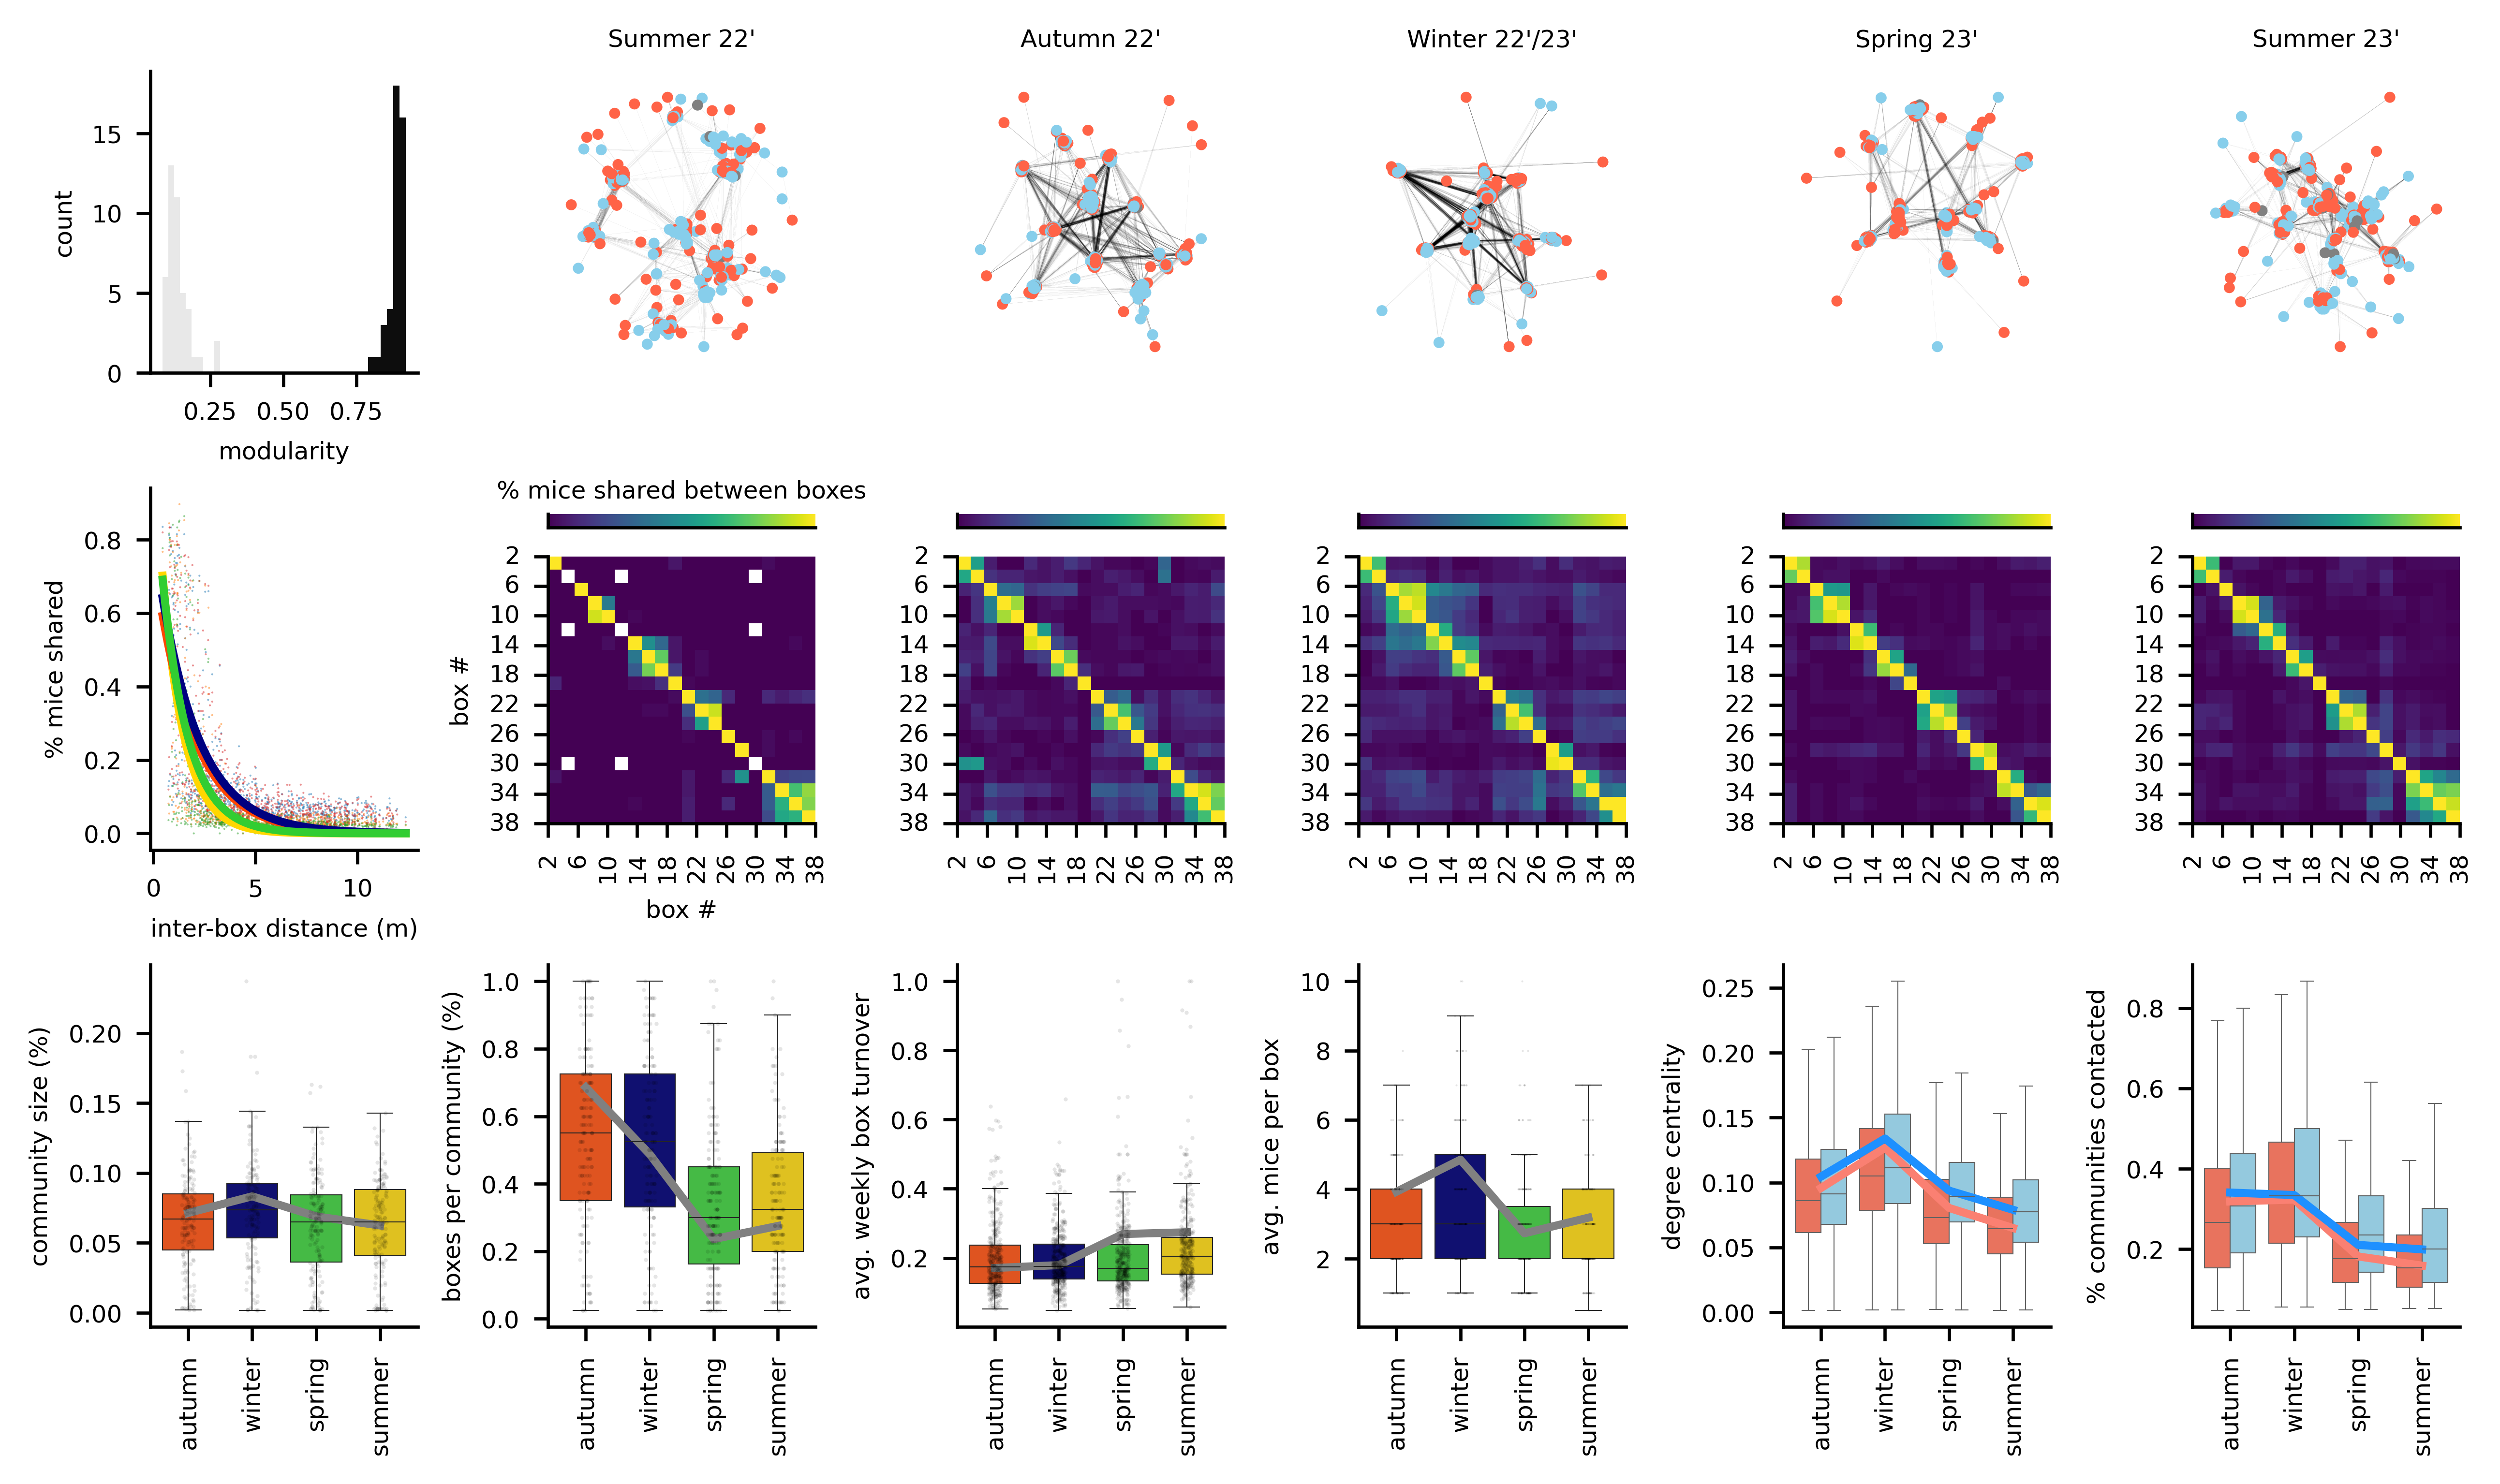

In [39]:
# save or not
save = False
path_to_save = '/Users/jourjine/Desktop/lindholm/barn_manuscript_final/procB_resubmission/resubmission_figures'
##################################################################################################

#set up the axes
fig, axes = plt.subplot_mosaic(mosaic="UUOOPPQQSSTT;"\
                                      "VVZZaabbccdd;"\
                                      "WWJJNNMMKKII",

                               figsize=[8.5,5], 
                               constrained_layout=True,
                               gridspec_kw={"height_ratios": [0.125,0.15,0.15]},
                               dpi=600)
# plotting parameters
tick_label_fontsize = 6
axis_label_fontsize = 9
title_label_fontsize = 12
num_ticks = 40 # for panel F x-axis
dot_size = .5
dot_alpha = .5
text_location = 4000
nth_mouse = 499


# ##################################################################################################
# # panels U : modularities
# ################################################################################################## 

# modularities_df['null_modularities'] = modularities_df['null_modularities'].apply(ast.literal_eval)
# Aggregate lists by season
def aggregate_lists(lists):
    aggregated = []
    for lst in lists:
        if not aggregated:
            aggregated = lst
        else:
            aggregated.extend(lst)
    return aggregated

# Group by season and aggregate the null_modularities
season_aggregates = modularities_df.groupby('season')['null_modularities'].apply(lambda x: aggregate_lists(x)).reset_index()
null_modularities = season_aggregates['null_modularities'].values[0]
actual_modularities = modularities_df['modularity_original'].values

# Plot histogram of null modularities using seaborn
sns.histplot(modularities_df['mu_null'], 
             ax=axes["U"], 
             color='lightgray', 
             alpha=0.5, 
             linewidth=0, 
             binwidth = 0.02,
             kde=False,  
             legend=False)

sns.histplot(actual_modularities, 
             ax=axes["U"], 
             color='black', 
             alpha=0.95, 
             linewidth=0, 
             binwidth = 0.02,
             kde=False,  
             legend=False)
    
# # Plot vertical lines for actual modularities
# cmap = cm.get_cmap('viridis')  # Use a colormap with enough distinct colors
# year_colors = {year: cmap(i / len(years)) for i, year in enumerate(years)}
    
# for _, row in modularities_df.iterrows():
#     modularity = row['modularity_original']
#     year = row['year']
#     season = row['season']
#     color = year_colors.get(year, 'black')  # Use 'black' if the year is not in the color map
    
#     if year in [2022,2023] and season == 'summer':
#         axes["U"].axvline(x=modularity, 
#                        color=seasons_palette['summer_22'], 
#                        linestyle='-', 
#                        linewidth=0.5)
        
#     elif year in [2022] and season == 'autumn':
#         axes["U"].axvline(x=modularity, 
#                        color=seasons_palette['autumn_22'], 
#                        linestyle='-', 
#                        linewidth=0.5)
        
#     elif year in [2022] and season == 'winter':
#         axes["U"].axvline(x=modularity, 
#                        color=seasons_palette['winter'], 
#                        linestyle='-', 
#                        linewidth=0.5)
        
#     elif year in [2022] and season == 'spring':
#         axes["U"].axvline(x=modularity, 
#                        color=seasons_palette['spring'], 
#                        linestyle='-', 
#                        linewidth=0.5)


# Format plot

axes["U"].set_xlabel('modularity', fontsize = tick_label_fontsize)
axes["U"].set_ylabel('count', fontsize = tick_label_fontsize)
axes["U"].tick_params(axis='both', which='major', labelsize=tick_label_fontsize)


# ##################################################################################################
# # panels U : mice shared across season
# ################################################################################################## 
        
# season_labels = {
#     'summer_22': 'sum 22',
#     'autumn_22': 'aut 22',
#     'winter': 'wint 22/23',
#     'spring': 'spring 23',
#     'summer_23': 'sum 23',
#     'autumn_23': 'aut 23'
# }


# divider = make_axes_locatable(axes["U"])
# Ucax = divider.append_axes("top", size="5%", pad=0.1)

# sns.heatmap(mice_shared_matrix, 
#             square = True,
#             annot=False, 
#             cmap='plasma', 
#             cbar=True, 
#             cbar_ax=Ucax, 
#             cbar_kws={'orientation': 'horizontal'},
#             ax = axes["U"])

# season_order_22_23 = ['summer_22', 'autumn_22', 'winter', 'spring', 'summer_23']

# axes["U"].figure.axes[-1].xaxis.label.set_size(tick_label_fontsize)
# axes["U"].figure.axes[-1].set_xlabel('')
# axes["U"].tick_params(which='both', labelsize = tick_label_fontsize)
# axes["U"].set_xticks(range(len(season_order_22_23)))
# axes["U"].set_yticks(range(len(season_order_22_23)))
# axes["U"].set_xticklabels([season_labels[season] for season in season_order_22_23], rotation=45, ha='right')
# axes["U"].set_yticklabels([season_labels[season] for season in season_order_22_23], rotation=0)

# cbar = axes["U"].collections[0].colorbar
# cbar.ax.xaxis.set_ticks([])
# cbar.ax.xaxis.set_ticklabels([])
# cbar.ax.xaxis.set_label_position('top')
# cbar.set_label('Fraction Mice Shared', fontsize=tick_label_fontsize)

##################################################################################################
# panels O, P, Q, S, T : example social networks by season colored by box
################################################################################################## 
season_pretty_names_dict = {
        'summer_22':"Summer 22'",
         'autumn_22':"Autumn 22'",
         'winter':"Winter 22'/23'",
         'spring':"Spring 23'",
        'summer_23':"Summer 23'",
         'autumn_23':"Autumn 23'",
    }
network_color_maps = ['tab20', 'tab20', 'tab20', 'tab20', 'tab20']
seasons = ['summer_22', 'autumn_22', 'winter', 'spring', 'summer_23']

for season, ax, cmap in zip(seasons, ["O", "P", "Q", "S", "T"], network_color_maps):
    axes[ax].axis('off')
    
    if season == 'summer_22':
        G = networks_dict[2022]['summer']
        community_ids = [i for i in G]
    elif season == 'autumn_22':
        G = networks_dict[2022]['autumn']
        community_ids = [i for i in G]
    elif season == 'winter':
        G = networks_dict[2022]['winter']
        community_ids = [i for i in G]
    elif season == 'spring':
        G = networks_dict[2023]['spring']
        community_ids = [i for i in G]
    elif season == 'summer_23':
        G = networks_dict[2023]['summer']
        community_ids = [i for i in G]
    
    # Get cluster IDs and colors
    box_colors_dict = plot.get_box_colors(save=False)
    box_cmap = ListedColormap(list(box_colors_dict.values()))
    community_cmap =  plt.get_cmap(cmap)
    #preferred_boxes = nx.get_node_attributes(G, 'preferred_box').values()
    #colors_box = [box_colors_dict[box] for box in preferred_boxes]
    colors_sex = [sex_colors.get(sex_dict.get(int(name), 'nan'), 'grey') for name in nx.get_node_attributes(G, 'name').values()]
    
    # Get community IDs
    community_ids = [G.nodes[node]['community_id'] for node in G.nodes()]
    unique_communities = list(set(community_ids))
    community_colors = {community: community_cmap(i / len(unique_communities)) for i, community in enumerate(unique_communities)}
    colors_community = [community_colors[community_id] for community_id in community_ids]

    # Plot the graph with node colors based on clusters
    pos = nx.spring_layout(G, seed=12345, iterations=100)  # Define node positions for better visualization

    nx.draw_networkx_nodes(G, 
                           pos, 
                           node_color=colors_sex, 
                           node_size=7.5, 
                           edgecolors='black', 
                           linewidths=0, 
                           ax=axes[ax])

    nx.draw_networkx_edges(G, 
                           pos, 
                           width=0.005, 
                           ax=axes[ax])  # Draw edges
    axes[ax].axis('off')
    axes[ax].set_title(season_pretty_names_dict[season], fontsize = tick_label_fontsize)

##################################################################################################
# panel V: distance between boxes
################################################################################################## 
from scipy.optimize import curve_fit

seasons_palette = parameters.load_json(os.path.join(root, 'parameters', 'json_files','season_color_dict.json'))

df = all_mice_shared_df_grouped
sns.scatterplot(data = df[df['box_1'] != df['box_2']], 
                x = 'distance', 
                y = 'fraction_mice_shared', 
                hue = 'season', 
                s = 0.25, 
                alpha = 0.5, 
                ax = axes["V"], linewidth = 0)

axes["V"].tick_params(axis='both', labelsize=tick_label_fontsize)
axes["V"].set_ylabel('% mice shared', fontsize = tick_label_fontsize)
axes["V"].set_xlabel('inter-box distance (m)', fontsize = tick_label_fontsize)
if hasattr(axes["V"], 'legend_') and axes["V"].legend_ is not None:
    axes["V"].legend_.remove()
    
# # Calculate new dimensions (80% of original)
# pos = axes["V"].get_position()
# new_width = pos.width * 0.95
# new_height = pos.height * 0.6

# # Calculate new position to keep it centered
# new_left = pos.x0 + (pos.width - new_width)*3 
# new_bottom = pos.y0 + (pos.width - new_width)*15

# # Set the new position
# axes["V"].set_position([new_left, new_bottom, new_width, new_height])


#exponential decay model - seems reasonable because fraction shared cannot be negative
def exp_decay(x, a, b):
    return a * np.exp(-b * x)


for season in ['summer', 'autumn', 'winter', 'spring']:
    season_data = df[(df['season'] == season) & (df['distance'] != 0)]
    x_data = season_data['distance']
    y_data = season_data['fraction_mice_shared']
    
    # Perform the curve fitting
    popt, _ = curve_fit(exp_decay, x_data, y_data, p0=(1, 0.01))
    
    # Plot the fitting curve starting from min_distance
    x_fit = np.linspace(df['distance'][df['distance']!=0].min(), x_data.max(), 100)
    y_fit = exp_decay(x_fit, *popt)
    
    axes["V"].plot(x_fit, 
                   y_fit, 
                   linestyle='-', 
                   linewidth=2, 
                   label=f'{season} fit', 
                   color = seasons_palette[season])

##################################################################################################
# panel z, a,b,c, d: mice shared across boxes by season
##################################################################################################   
    
for season, ax in zip(['summer_22', 'autumn_22', 'winter', 'spring', 'summer_23'], ["Z","a", "b", "c", "d"]):
    
    if season == 'summer_22':
        
        divider = make_axes_locatable(axes[ax])
        cax = divider.append_axes("top", size="5%", pad=0.1)
        
        sns.heatmap(pd.DataFrame(overlap_matrix_22_23[season]), 
                    square = True,
                    cmap = 'viridis', 
                    ax=axes[ax], 
                    cbar_kws={'orientation': 'horizontal'},
                    cbar_ax=cax, 
                    cbar = True)
        
        axes[ax].set_xticks(np.linspace(0,20, 10))
        axes[ax].set_xticklabels(np.arange(2,42,4), rotation=90, size=tick_label_fontsize)
        axes[ax].set_yticks(np.linspace(0,20, 10))
        axes[ax].set_yticklabels(np.arange(2,42,4), rotation=0, size=tick_label_fontsize)
        axes[ax].tick_params(which='both', labelsize = tick_label_fontsize)
        axes[ax].set_ylabel('box #', fontsize = tick_label_fontsize)
        axes[ax].set_xlabel('box #', fontsize = tick_label_fontsize)
        cbar = axes[ax].collections[0].colorbar
        cbar.ax.xaxis.set_ticks([])
        cbar.ax.xaxis.set_ticklabels([])
        cbar.ax.xaxis.set_label_position('top')
        cbar.set_label('% mice shared between boxes', fontsize=tick_label_fontsize)
        
        
    else:
        divider = make_axes_locatable(axes[ax])
        cax = divider.append_axes("top", size="5%", pad=0.1)
        
        sns.heatmap(pd.DataFrame(overlap_matrix_22_23[season]), 
                    square = True,
                    cmap = 'viridis', 
                    ax=axes[ax], 
                    cbar_kws={'orientation': 'horizontal'},
                    cbar_ax=cax, 
                    cbar = True)
        
        axes[ax].set_xticks(np.linspace(0,20, 10))
        axes[ax].set_xticklabels(np.arange(2,42,4), rotation=90, size=tick_label_fontsize)
        axes[ax].set_yticks(np.linspace(0,20, 10))
        axes[ax].set_yticklabels(np.arange(2,42,4), rotation=0, size=tick_label_fontsize)
        axes[ax].tick_params(which='both', labelsize = tick_label_fontsize)
        cbar = axes[ax].collections[0].colorbar
        cbar.ax.xaxis.set_ticks([])
        cbar.ax.xaxis.set_ticklabels([])

##################################################################################################
# panel W,J,K,M, N: other network metrics by season
################################################################################################## 
agg_turnover_df = turnover_df.groupby(['year', 'season', 'box']).agg(avg_seasonal_turnover=('turnover','mean')).reset_index()
dot_alpha = 0.25

# community size relative to total population
season_order = ['autumn', 'winter', 'spring', 'summer']
social_network_metadata['Season'] = pd.Categorical(social_network_metadata['Season'], 
                                         categories=season_order, 
                                         ordered=True)
sns.boxplot(ax = axes["W"], 
            data = social_network_metadata, 
            x = 'Season', 
            linewidth = 0.25,
            y = 'percent_total_population', 
            order = ['autumn', 'winter', 'spring', 'summer'], 
            showfliers = False, palette=seasons_palette)
sns.stripplot(ax = axes["W"], 
              data = social_network_metadata, 
              x = 'Season', 
              y = 'percent_total_population', 
              c= 'k', 
              s = 1, 
              alpha = 0.1,
              order = ['autumn', 'winter', 'spring', 'summer'])
sns.lineplot(ax = axes["W"], 
              data = social_network_metadata[social_network_metadata['Year'].isin([2022,2023])], 
              x = 'Season', 
              y = 'percent_total_population', 
              linewidth = 2, 
             color = 'gray', 
             errorbar = None)


# boxes occupied per cluster
season_order = ['autumn', 'winter', 'spring', 'summer']
boxes_per_cluster_df['season'] = pd.Categorical(boxes_per_cluster_df['season'], 
                                         categories=season_order, 
                                         ordered=True)
sns.boxplot(ax = axes["J"], 
            data = boxes_per_cluster_df, 
            x = 'season', 
            linewidth = 0.25,
            y = 'percent_boxes_occupied', 
            order = ['autumn', 'winter', 'spring', 'summer'], 
            showfliers = False, palette=seasons_palette)
sns.stripplot(ax = axes["J"], 
              data = boxes_per_cluster_df, 
              x = 'season', 
              y = 'percent_boxes_occupied', 
              c= 'k', 
              s = 1, 
              alpha = 0.1,
              order = ['autumn', 'winter', 'spring', 'summer'])
sns.lineplot(ax = axes["J"], 
              data = boxes_per_cluster_df[boxes_per_cluster_df['year'].isin([2022,2023])], 
              x = 'season', 
              y = 'percent_boxes_occupied', 
              linewidth = 2, 
             color = 'gray', 
             errorbar = None)

#mice per box
season_order = ['autumn', 'winter', 'spring', 'summer']
average_num_mice_per_box_by_year_season['season'] = pd.Categorical(average_num_mice_per_box_by_year_season['season'], 
                                         categories=season_order, 
                                         ordered=True)
sns.boxplot(ax = axes["M"], 
            data = average_num_mice_per_box_by_year_season, 
            x = 'season', 
            linewidth = 0.25,
            y = 'average_num_mice_per_box', 
            order = ['autumn', 'winter', 'spring', 'summer'], 
            showfliers = False, palette=seasons_palette)
sns.stripplot(ax = axes["M"], 
              data = average_num_mice_per_box_by_year_season, 
              x = 'season', 
              y = 'average_num_mice_per_box', 
              c= 'k', 
              s = dot_size, 
              alpha = 0.1,
              order = ['autumn', 'winter', 'spring', 'summer'])
sns.lineplot(ax = axes["M"], 
              data = average_num_mice_per_box_by_year_season[average_num_mice_per_box_by_year_season['year'].isin([2022,2023])], 
              x = 'season', 
              y = 'average_num_mice_per_box', 
              linewidth = 2, 
             color = 'gray', 
             errorbar = None)

# weekly box turnover 
season_order = ['autumn', 'winter', 'spring', 'summer']
turnover_df['season'] = pd.Categorical(turnover_df['season'], 
                                         categories=season_order, 
                                         ordered=True)

agg_turnover_df['season'] = pd.Categorical(agg_turnover_df['season'], 
                                         categories=season_order, 
                                         ordered=True)
sns.boxplot(ax = axes["N"], 
                data = agg_turnover_df, 
                x = 'season', 
                linewidth = 0.25,
                y = 'avg_seasonal_turnover',
                order = ['autumn', 'winter', 'spring', 'summer'], 
                showfliers = False, palette=seasons_palette)
sns.stripplot(ax = axes["N"], 
              data = agg_turnover_df, 
              x = 'season', 
              y = 'avg_seasonal_turnover', 
              c= 'k', 
              s = 1 , 
              alpha = 0.1,
              order = ['autumn', 'winter', 'spring', 'summer'])
sns.lineplot(ax = axes["N"], 
              data =agg_turnover_df[agg_turnover_df['year'].isin([2022,2023])], 
              x = 'season', 
              y = 'avg_seasonal_turnover', 
              linewidth = 2, 
             color = 'gray', 
             errorbar = None)

sex_colors = {'M':'tomato', 'F':'skyblue'}


season_order = ['autumn', 'winter', 'spring', 'summer']
centrality_df['season'] = pd.Categorical(centrality_df['season'], 
                                         categories=season_order, 
                                         ordered=True)
sns.boxplot(data = centrality_df, 
            x = 'season', 
            y = 'centrality', 
            hue = 'sex', 
            palette = sex_colors,
            linewidth = 0.25, 
            showfliers = False, 
            order = season_order, 
            ax = axes["K"])
sns.lineplot(data = centrality_df[centrality_df['year'].isin([2022,2023])], 
             x = 'season', 
             y = 'centrality',
             linewidth = 2, 
             color = 'black', hue = 'sex', 
             palette = {'M':'salmon', 'F':'dodgerblue'},
             errorbar = None, 
             ax = axes["K"])

#number communities a mouse interacts with
community_connections_df['season'] = pd.Categorical(community_connections_df['season'], 
                                         categories=season_order, 
                                         ordered=True)
sns.boxplot(ax = axes["I"], 
            data = community_connections_df, 
            x = 'season', 
            hue = 'sex', 
            linewidth = 0.25,
            y = 'percent_communities_connected', 
            order = ['autumn', 'winter', 'spring', 'summer'], 
            showfliers = False, 
            palette = sex_colors,)

sns.lineplot(data = community_connections_df[community_connections_df['year'].isin([2022,2023])], 
             x = 'season', 
             y = 'percent_communities_connected',
             linewidth = 2, 
             color = 'black', hue = 'sex', 
             palette = {'M':'salmon', 'F':'dodgerblue'},
             errorbar = None, 
             ax = axes["I"])

for ax,label in zip(["W",  "J", "M", "N", "I", "K"], ["community size (%)", "boxes per community (%)", "avg. mice per box","avg. weekly box turnover",  "% communities contacted", "degree centrality"]):
    
    # Rotate x-axis tick labels
    axes[ax].tick_params(axis='x', labelrotation=90)

    # Set tick label font size
    axes[ax].tick_params(axis='both', labelsize=tick_label_fontsize)
    axes[ax].set_ylabel(label, fontsize = tick_label_fontsize)
    if hasattr(axes[ax], 'legend_') and axes[ax].legend_ is not None:
        axes[ax].legend_.remove()
    axes[ax].set_xlabel('')

sns.despine()

#save
if save:
    plt.savefig(os.path.join(path_to_save, 'Figure3_revision_v2.svg'))
    plt.savefig(os.path.join(path_to_save, 'Figure3_revision_v2.jpeg'), dpi = 600)


# Statistics

In [46]:
import statsmodels.stats.multicomp as multi
import statsmodels.stats.multitest as smm
from statsmodels.formula.api import ols
from docx import Document
from docx.shared import Inches
from src import modelselection
import scipy.stats as stats
from scipy.stats import ttest_rel

In [51]:
resubmission_statistics = '/Users/jourjine/Desktop/lindholm/barn_manuscript_final/procB_resubmission/resubmission_statistics/figure_3'
save = False # if true, save statistics csvs and output to resubmission_statistics


## Panel A

In [50]:
t_stat, p_value = ttest_rel(modularities_df['modularity_original'], modularities_df['mu_null'])
print(f'p_value: {p_value}\n'
      f't_stat: {t_stat}')

p_value:1.7440562355408947e-48
t_stat:84.28664116576186


## Panel E
community size (%) ~ season

In [52]:
data = social_network_metadata
dependent_var = 'percent_total_population'
independent_var = 'Season'
data = data.dropna(subset = dependent_var)
analysis_name = 'figure3_panelE'

# Ensure 'season' is treated as categorical and ordered
season_order = ['autumn', 'winter', 'spring', 'summer']
data[independent_var] = pd.Categorical(data[independent_var], categories=season_order, ordered=True)

# Fit the one-way ANOVA model
formula = dependent_var + f" ~ C({independent_var})"
model = ols(formula, data=data).fit()

# Generate and print the ANOVA table
anova_table = sm.stats.anova_lm(model)
print(anova_table)

# Perform Tukey's HSD post-hoc test
mc = multi.MultiComparison(data[dependent_var], data[independent_var])
tukey_result = mc.tukeyhsd()
tukey_result = pd.DataFrame(data=tukey_result.summary().data[1:], columns=tukey_result.summary().data[0])

# Print the results of the Tukey HSD test
print(tukey_result)

if save:
    
    #save the analysis results
    modelselection.save_ANOVA_tables_to_word(analysis_name+': '+formula, anova_table, tukey_result, os.path.join(resubmission_statistics, analysis_name +'.docx'))
    
    #save the data the analysis was run on
    data.to_csv(os.path.join(resubmission_statistics, analysis_name + '.csv'), index = False)

              df    sum_sq   mean_sq         F    PR(>F)
C(Season)    3.0  0.012713  0.004238  3.417589  0.017092
Residual   650.0  0.805970  0.001240       NaN       NaN
   group1  group2  meandiff   p-adj   lower   upper  reject
0  autumn  spring   -0.0030  0.8588 -0.0128  0.0068   False
1  autumn  summer   -0.0041  0.7103 -0.0141  0.0059   False
2  autumn  winter    0.0075  0.2357 -0.0027  0.0177   False
3  spring  summer   -0.0011  0.9912 -0.0110  0.0088   False
4  spring  winter    0.0105  0.0384  0.0004  0.0206    True
5  summer  winter    0.0116  0.0196  0.0013  0.0219    True


## Panel F
boxes occupied per community ~ season

In [58]:
data = boxes_per_cluster_df
dependent_var = 'percent_boxes_occupied'
independent_var = 'season'
data = data.dropna(subset = dependent_var)
analysis_name = 'figure3_panelF'

#'season' is categorical
season_order = ['autumn', 'winter', 'spring', 'summer']
data[independent_var] = pd.Categorical(data[independent_var], categories=season_order, ordered=True)

# Fit the one-way ANOVA model
formula = dependent_var + f" ~ C({independent_var})"
model = ols(formula, data=data).fit()

# Generate and print the ANOVA table
anova_table = sm.stats.anova_lm(model)
print(anova_table)

# Perform Tukey's HSD post-hoc test
mc = multi.MultiComparison(data[dependent_var], data[independent_var])
tukey_result = mc.tukeyhsd()
tukey_result = pd.DataFrame(data=tukey_result.summary().data[1:], columns=tukey_result.summary().data[0])

# Print the results of the Tukey HSD test
print(tukey_result)

if save:
    
    #save the analysis results
    modelselection.save_ANOVA_tables_to_word(analysis_name+': '+formula, anova_table, tukey_result, os.path.join(resubmission_statistics, analysis_name +'.docx'))
    
    #save the data the analysis was run on
    data.to_csv(os.path.join(resubmission_statistics, analysis_name + '.csv'), index = False)

              df     sum_sq   mean_sq          F        PR(>F)
C(season)    3.0   5.344962  1.781654  31.405781  5.741799e-19
Residual   650.0  36.874587  0.056730        NaN           NaN
   group1  group2  meandiff   p-adj   lower   upper  reject
0  autumn  spring   -0.1929  0.0000 -0.2593 -0.1265    True
1  autumn  summer   -0.1855  0.0000 -0.2531 -0.1178    True
2  autumn  winter   -0.0190  0.8930 -0.0880  0.0500   False
3  spring  summer    0.0074  0.9919 -0.0595  0.0743   False
4  spring  winter    0.1739  0.0000  0.1056  0.2421    True
5  summer  winter    0.1665  0.0000  0.0969  0.2360    True


## Panel G

average weekly box turnover per season ~ season

In [53]:
turnover_df = pd.read_csv(os.path.join(temporary_tables,'weekly_turnover', 'turnover_from_allstays.csv'))
avg_turnover_df = turnover_df.groupby(['year', 'season', 'box']).agg(avg_seasonal_turnover=('turnover','mean')).reset_index()
data = avg_turnover_df
dependent_var = 'avg_seasonal_turnover'
independent_var = 'season'
data = data.dropna(subset = dependent_var)
analysis_name = 'figure3_panelG'

#'season' is categorical
season_order = ['autumn', 'winter', 'spring', 'summer']
data[independent_var] = pd.Categorical(data[independent_var], categories=season_order, ordered=True)

# Fit the one-way ANOVA model
formula = dependent_var + f" ~ C({independent_var})"
model = ols(formula , data=data).fit()

# Generate and print the ANOVA table
anova_table = sm.stats.anova_lm(model)
print(anova_table)

# Perform Tukey's HSD post-hoc test
mc = multi.MultiComparison(data[dependent_var], data[independent_var])
tukey_result = mc.tukeyhsd()
tukey_result = pd.DataFrame(data=tukey_result.summary().data[1:], columns=tukey_result.summary().data[0])

# Print the results of the Tukey HSD test
print(tukey_result)

if save:
    
    #save the analysis results
    modelselection.save_ANOVA_tables_to_word(analysis_name+': '+formula, anova_table, tukey_result, os.path.join(resubmission_statistics, analysis_name +'.docx'))
    
    #save the data the analysis was run on
    data.to_csv(os.path.join(resubmission_statistics, analysis_name + '.csv'), index = False)

/var/folders/h6/6fyt3jld5pq_w03ql1jw0gnh0000gn/T/ipykernel_7542/2034366040.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[independent_var] = pd.Categorical(data[independent_var], categories=season_order, ordered=True)


               df     sum_sq   mean_sq       F    PR(>F)
C(season)     3.0   0.285997  0.095332  7.7527  0.000039
Residual   1468.0  18.051517  0.012297     NaN       NaN
   group1  group2  meandiff   p-adj   lower   upper  reject
0  autumn  spring    0.0041  0.9600 -0.0170  0.0251   False
1  autumn  summer    0.0329  0.0005  0.0113  0.0546    True
2  autumn  winter   -0.0029  0.9838 -0.0236  0.0178   False
3  spring  summer    0.0289  0.0030  0.0075  0.0503    True
4  spring  winter   -0.0070  0.8174 -0.0275  0.0135   False
5  summer  winter   -0.0358  0.0001 -0.0569 -0.0148    True


## Panel H

Mice per box ~ season

In [54]:
data = average_num_mice_per_box_by_year_season
dependent_var = 'average_num_mice_per_box'
independent_var = 'season'
data[dependent_var] = data[dependent_var].astype(float)
data = data.dropna(subset = dependent_var)
analysis_name = 'figure3_panelH'

#'season' is categorical
season_order = ['autumn', 'winter', 'spring', 'summer']
data[independent_var] = pd.Categorical(data[independent_var], categories=season_order, ordered=True)

# Fit the one-way ANOVA model
formula = dependent_var + f" ~ C({independent_var})"
model = ols(formula, data=data).fit()

# Generate and print the ANOVA table
anova_table = sm.stats.anova_lm(model)
print(anova_table)

# Perform Tukey's HSD post-hoc test
mc = multi.MultiComparison(data[dependent_var], data[independent_var])
tukey_result = mc.tukeyhsd()
tukey_result = pd.DataFrame(data=tukey_result.summary().data[1:], columns=tukey_result.summary().data[0])

# Print the results of the Tukey HSD test
print(tukey_result)

if save:
    
    #save the analysis results
    modelselection.save_ANOVA_tables_to_word(analysis_name+': '+formula, anova_table, tukey_result, os.path.join(resubmission_statistics, analysis_name +'.docx'))
    
    #save the data the analysis was run on
    data.to_csv(os.path.join(resubmission_statistics, analysis_name + '.csv'), index = False)

              df       sum_sq    mean_sq          F        PR(>F)
C(season)    3.0   133.240748  44.413583  15.936715  4.369898e-10
Residual   844.0  2352.119806   2.786872        NaN           NaN
   group1  group2  meandiff   p-adj   lower   upper  reject
0  autumn  spring   -0.1772  0.6854 -0.5893  0.2349   False
1  autumn  summer   -0.1502  0.8004 -0.5759  0.2754   False
2  autumn  winter    0.7830  0.0000  0.3714  1.1946    True
3  spring  summer    0.0270  0.9984 -0.3973  0.4513   False
4  spring  winter    0.9602  0.0000  0.5500  1.3704    True
5  summer  winter    0.9332  0.0000  0.5094  1.3570    True


## Panel I

node centrality ~ (season) * (sex)

In [55]:
data = centrality_df
dependent_var = 'centrality'
analysis_name = 'figure3_panelI'
data = data.dropna(subset = ['sex', dependent_var])

formula = dependent_var + ' ~ C(season) * C(sex)'
model = ols(formula, data=data).fit()
anova_table = sm.stats.anova_lm(model)
print(anova_table)

# Combine season and sex into a single factor
data['group'] = data['season'].astype(str) + '-' + data['sex'].astype(str)

# Perform Tukey's HSD post-hoc test
mc = multi.MultiComparison(data[dependent_var], data['group'])
tukey_result = mc.tukeyhsd()
tukey_df = pd.DataFrame(data=tukey_result.summary().data[1:], columns=tukey_result.summary().data[0])

# Filter to just show comparisons within seasons
def is_same_season(row):
    group1_season = row['group1'].split('-')[0]
    group2_season = row['group2'].split('-')[0]
    return group1_season == group2_season

tukey_result = tukey_df[tukey_df.apply(is_same_season, axis=1)]
print(tukey_result)

if save:
    
    #save the analysis results
    modelselection.save_ANOVA_tables_to_word(analysis_name+': '+formula, anova_table, tukey_result, os.path.join(resubmission_statistics, analysis_name +'.docx'))
    
    #save the data the analysis was run on
    data.to_csv(os.path.join(resubmission_statistics, analysis_name + '.csv'), index = False)

                       df     sum_sq   mean_sq           F        PR(>F)
C(season)             3.0   4.610397  1.536799  673.717557  0.000000e+00
C(sex)                1.0   0.560945  0.560945  245.912715  4.784338e-55
C(season):C(sex)      3.0   0.042138  0.014046    6.157669  3.528505e-04
Residual          17521.0  39.966682  0.002281         NaN           NaN


/var/folders/h6/6fyt3jld5pq_w03ql1jw0gnh0000gn/T/ipykernel_7542/1425029089.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['group'] = data['season'].astype(str) + '-' + data['sex'].astype(str)


      group1    group2  meandiff  p-adj   lower   upper  reject
0   autumn-F  autumn-M   -0.0075    0.0 -0.0118 -0.0032    True
13  spring-F  spring-M   -0.0162    0.0 -0.0208 -0.0116    True
22  summer-F  summer-M   -0.0124    0.0 -0.0167 -0.0081    True
27  winter-F  winter-M   -0.0105    0.0 -0.0152 -0.0058    True


## Panel J

percent communities contacted ~ (season) * (sex)

In [56]:
data = community_connections_df
dependent_var = 'percent_communities_connected'
analysis_name = 'figure3_panelJ'
data = data.dropna(subset='sex')
data= data.dropna(subset = dependent_var)

formula = dependent_var + ' ~ C(season) * C(sex)'
model = ols(formula, data=data).fit()
anova_table = sm.stats.anova_lm(model)
print(anova_table)

# Combine season and sex into a single factor
data['group'] = data['season'].astype(str) + '-' + data['sex'].astype(str)

# Perform Tukey's HSD post-hoc test
mc = multi.MultiComparison(data[dependent_var], data['group'])
tukey_result = mc.tukeyhsd()
tukey_df = pd.DataFrame(data=tukey_result.summary().data[1:], columns=tukey_result.summary().data[0])

# Filter to just show comparisons within seasons
def is_same_season(row):
    group1_season = row['group1'].split('-')[0]
    group2_season = row['group2'].split('-')[0]
    return group1_season == group2_season

tukey_result = tukey_df[tukey_df.apply(is_same_season, axis=1)]
print(tukey_result)

if save:
    
    #save the analysis results
    modelselection.save_ANOVA_tables_to_word(analysis_name+': '+formula, anova_table, tukey_result, os.path.join(resubmission_statistics, analysis_name +'.docx'))
    
    #save the data the analysis was run on
    data.to_csv(os.path.join(resubmission_statistics, analysis_name + '.csv'), index = False)

                       df      sum_sq    mean_sq           F        PR(>F)
C(season)             3.0   67.247607  22.415869  948.748276  0.000000e+00
C(sex)                1.0    4.025736   4.025736  170.388661  9.228342e-39
C(season):C(sex)      3.0    0.646976   0.215659    9.127725  4.941865e-06
Residual          17521.0  413.964851   0.023627         NaN           NaN
      group1    group2  meandiff   p-adj   lower   upper  reject
0   autumn-F  autumn-M   -0.0215  0.0001 -0.0354 -0.0076    True
13  spring-F  spring-M   -0.0502  0.0000 -0.0651 -0.0354    True
22  summer-F  summer-M   -0.0346  0.0000 -0.0485 -0.0208    True
27  winter-F  winter-M   -0.0179  0.0075 -0.0329 -0.0029    True
